# Projet de séries temporelles: Modèles de Deep Learning

Ce notebook présente une partie des travaux qui ont été réalisés sur le cours du CAC40 dans le cadre du projet de séries temporelles par le groupe d'étudiants GDR composé par: Mariyam OUYASSIN, Cheryl KOUADIO, Marilene MOKO, Mathis BOUILLON et Mountaga WANE. Nous traiterons ici uniquement des approches deep learning / réseaux de neurones, LSTM (Long Short Term Memory) et GRU (Gated Recurrent Unit) en particulier.

A la toute fin de ce notebook, des parties dédiées qui présentent les meilleurs modèles obtenus en fonction de l'architecture et du type de données utilisées ont été ajoutées. Chacune a été écrite de façon à pouvoir être exécutée indépendamment pour chaque modèle.

## Etude préliminaire

Importation de packages nécessaires

In [ ]:
pip install numpy pandas matplotlib scikit-learn tensorflow yfinance


In [ ]:
import yfinance as yf

# données du CAC40 (^FCHI)
data = yf.download("^FCHI", start="1990-01-01", end="2023-12-31", interval="1d")

# aperçu
print(data.head())

# on extrait les prix de clôture
close_prices = data["Close"]


[*********************100%***********************]  1 of 1 completed

Price        Close    High     Low    Open Volume
Ticker       ^FCHI   ^FCHI   ^FCHI   ^FCHI  ^FCHI
Date                                             
1990-03-01  1832.0  1838.0  1827.0  1836.0      0
1990-03-02  1860.0  1860.0  1831.0  1831.0      0
1990-03-05  1874.0  1874.0  1862.0  1866.0      0
1990-03-06  1872.0  1875.0  1866.0  1869.0      0
1990-03-07  1880.0  1881.0  1874.0  1874.0      0


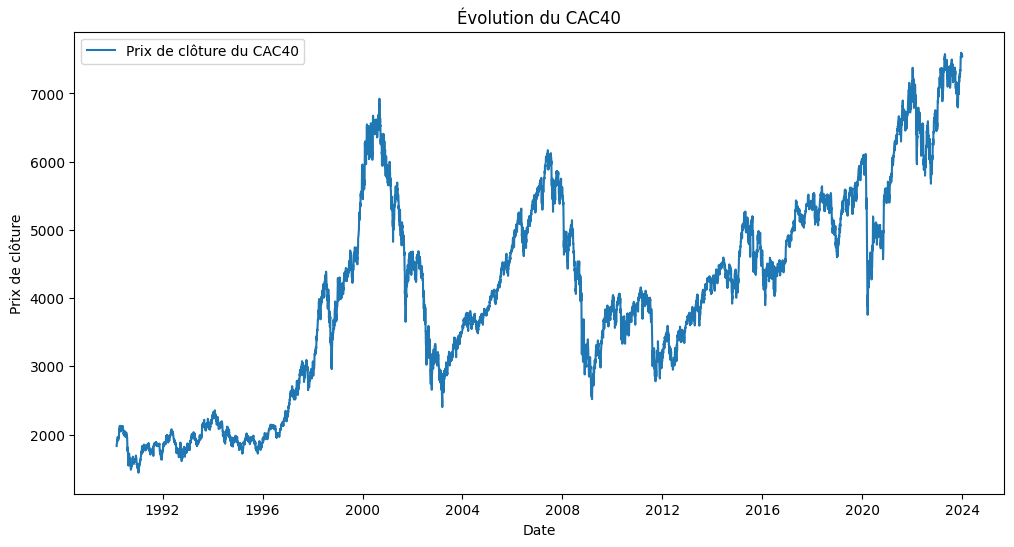

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(close_prices, label="Prix de clôture du CAC40")
plt.title("Évolution du CAC40")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.legend()
plt.show()


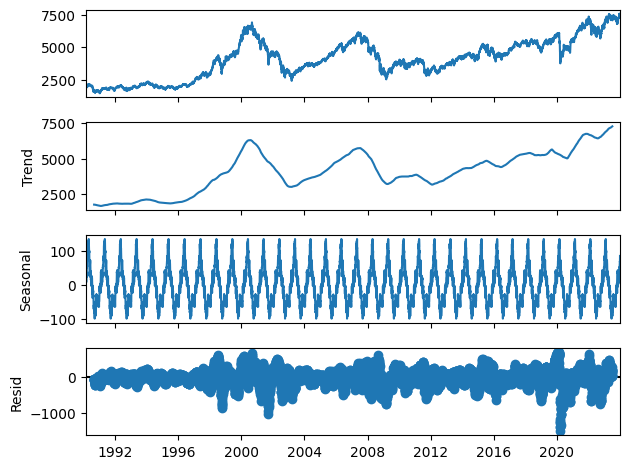

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(close_prices, model="additive", period=252)  # Période de 252 jours pour les données financières

# décomposition
result.plot()
plt.show()


In [ ]:
print("Statistiques descriptives :")
print(close_prices.describe())

# Vérification des variations (différences quotidiennes)
daily_returns = close_prices.pct_change().dropna()
print("\nStatistiques des variations journalières :")
print(daily_returns.describe())


Statistiques descriptives :
Ticker        ^FCHI
count   8590.000000
mean    4094.828829
std     1502.747780
min     1441.000000
25%     3002.599976
50%     4122.800049
75%     5189.972412
max     7596.910156

Statistiques des variations journalières :
Ticker        ^FCHI
count   8589.000000
mean       0.000257
std        0.013561
min       -0.122768
25%       -0.006473
50%        0.000440
75%        0.007305
max        0.111762


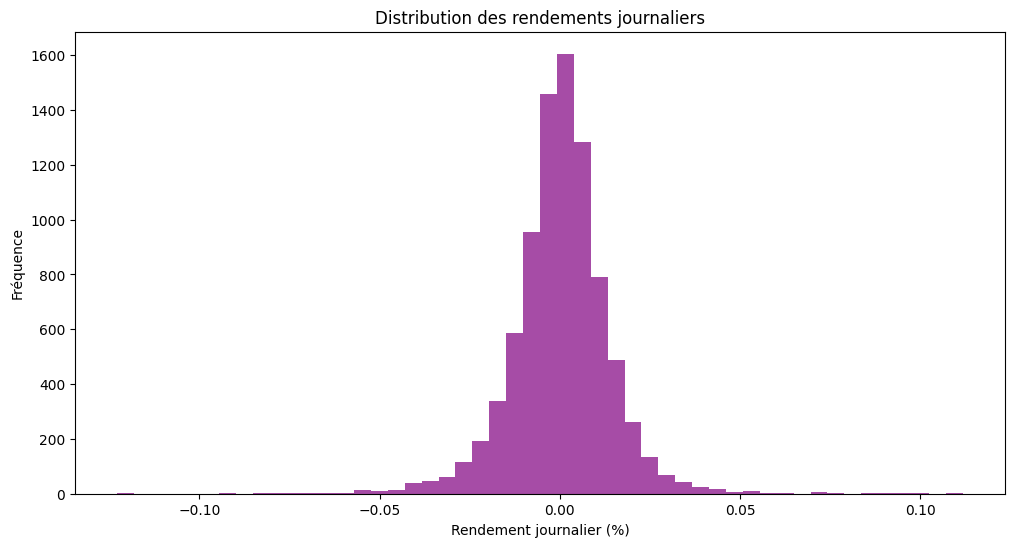

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(daily_returns, bins=50, color="purple", alpha=0.7)
plt.title("Distribution des rendements journaliers")
plt.xlabel("Rendement journalier (%)")
plt.ylabel("Fréquence")
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(close_prices.dropna())
print("Test de Dickey-Fuller augmenté :")
print(f"Statistique ADF : {adf_test[0]}")
print(f"p-value : {adf_test[1]}")

if adf_test[1] < 0.05:
    print("La série est stationnaire (p-value < 0.05).")
else:
    print("La série n'est pas stationnaire (p-value >= 0.05).")


Test de Dickey-Fuller augmenté :
Statistique ADF : -1.00092046520616
p-value : 0.7529284346337848
La série n'est pas stationnaire (p-value >= 0.05).


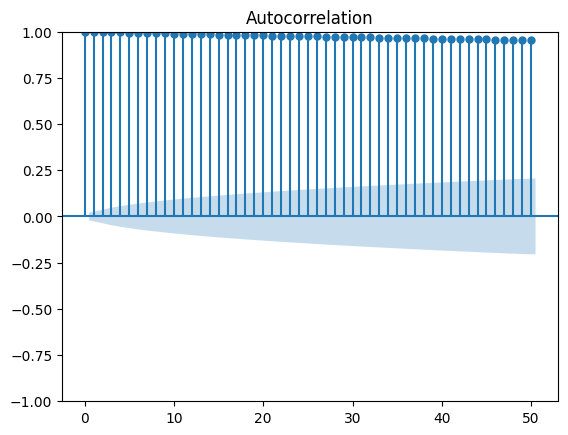

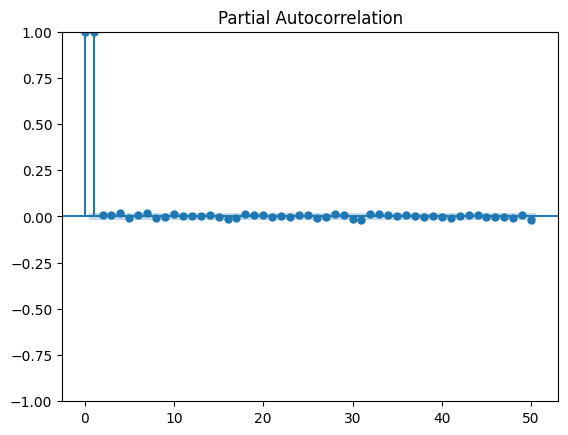

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrélation
plot_acf(close_prices.dropna(), lags=50)
plt.show()

# Autocorrélation partielle
plot_pacf(close_prices.dropna(), lags=50)
plt.show()


In [ ]:
# Première différence
diff_prices = close_prices.diff().dropna()

# on fait un test ADF sur la différenciation
from statsmodels.tsa.stattools import adfuller
adf_test_diff = adfuller(diff_prices)
print("Test ADF après différenciation :")
print(f"Statistique ADF : {adf_test_diff[0]}")
print(f"p-value : {adf_test_diff[1]}")

if adf_test_diff[1] < 0.05:
    print("La série différenciée est stationnaire (p-value < 0.05).")
else:
    print("La série différenciée n'est pas stationnaire (p-value >= 0.05).")


Test ADF après différenciation :
Statistique ADF : -16.70902743344267
p-value : 1.439837803376815e-29
La série différenciée est stationnaire (p-value < 0.05).


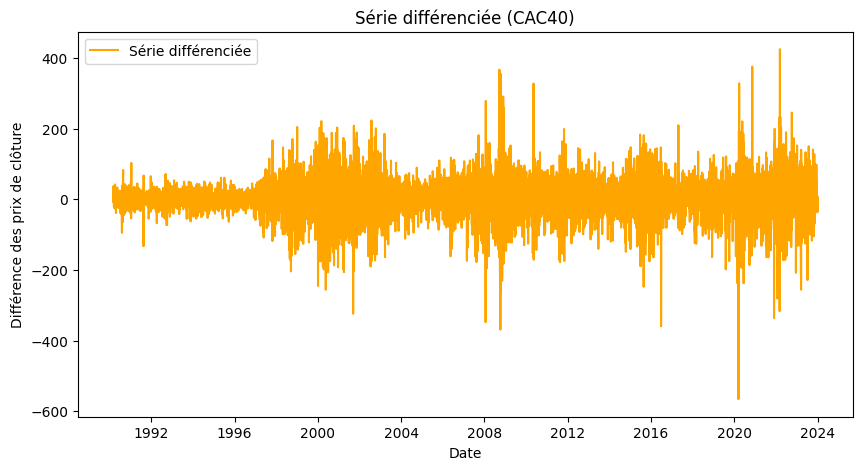

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(diff_prices, label="Série différenciée", color="orange")
plt.title("Série différenciée (CAC40)")
plt.xlabel("Date")
plt.ylabel("Différence des prix de clôture")
plt.legend()
plt.show()


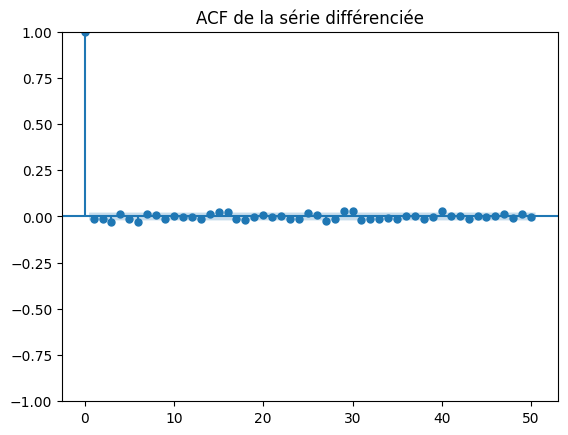

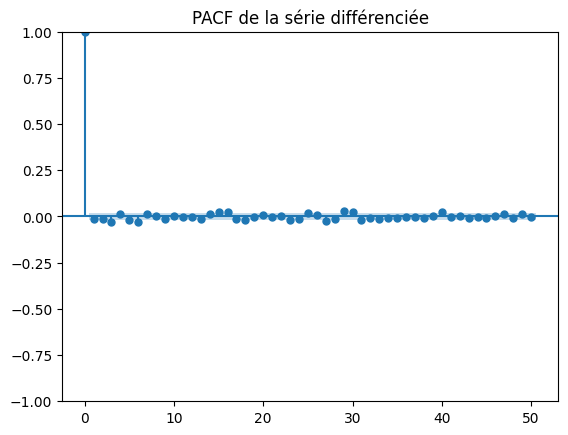

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_prices, lags=50)
plt.title("ACF de la série différenciée")
plt.show()

plot_pacf(diff_prices, lags=50)
plt.title("PACF de la série différenciée")
plt.show()


## LSTM: étude purement temporelle

On va d'abord travailler avec la série brute car les LSTM, les réseaux de neurones en général arrivent à travailler avec des architectures complexes de ce type. De plus, lors de prédictions, nous aurons directement le cours de l'action sans qu'il n'y ait besoin de faire des calculs de conversions supplémentaires avec la série différenciée.

Si les résultats fournis avec cette approche ne sont pas convaincants, nous essayerons avec la série différenciée.

PS: il s'avère que les résultats étaient satisfaisants avec la série brute, donc nous n'avons pas fait d'études avec la série différenciée, ou la série des log returns.

Pour les réseaux de neurones, il est important de normaliser les données d'entrée. En effet, celà permet d'améliorer la convergence lors de l'entraînement, notamment lors de la descente de gradients et l'actualisation des poids d'apprentissage.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(close_prices.values.reshape(-1, 1))


L'apprentissage avec LSTM fonctionne avec des séquences temporelles.  Il s'agit de séries d'observations sur un temps déterminé qui sont utilisées pour faire des prédictions.

In [ ]:
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

SEQ_LENGTH = 60  # Par exemple, utiliser 60 jours pour prédire le jour suivant
x, y = create_sequences(scaled_prices, SEQ_LENGTH)


In [ ]:
# séparation en échantillons d'apprentissage et test

split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Vérification des dimensions
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")


x_train shape: (6824, 60, 1), x_test shape: (1706, 60, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Une seule sortie pour prédire la prochaine valeur
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 0.0160 - val_loss: 4.5287e-04
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0013 - val_loss: 5.9428e-04
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - loss: 9.5708e-04 - val_loss: 5.4202e-04
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - loss: 8.2180e-04 - val_loss: 4.1825e-04
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 6.7347e-04 - val_loss: 3.8435e-04
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 6.3762e-04 - val_loss: 3.0331e-04
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 5.9338e-04 - val_loss: 3.0730e-04
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 5.3210e-04 - val_loss: 2.8841e-04
Epoch 9/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - loss: 5.3819e-04 - val_loss: 2.9695e-04
Epoch 10/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 5.4904e-04 - val_loss: 3.7744e-04
Epoch 11/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 65

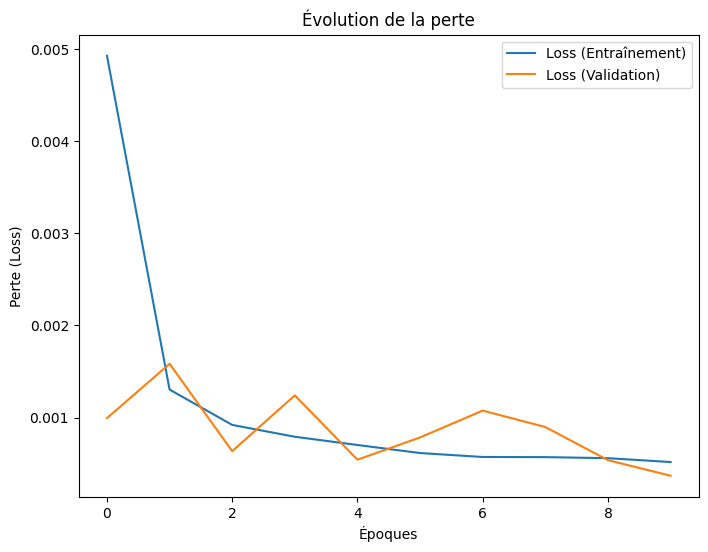

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # remettre à l'échelle d'origine pour pouvoir comparer après


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


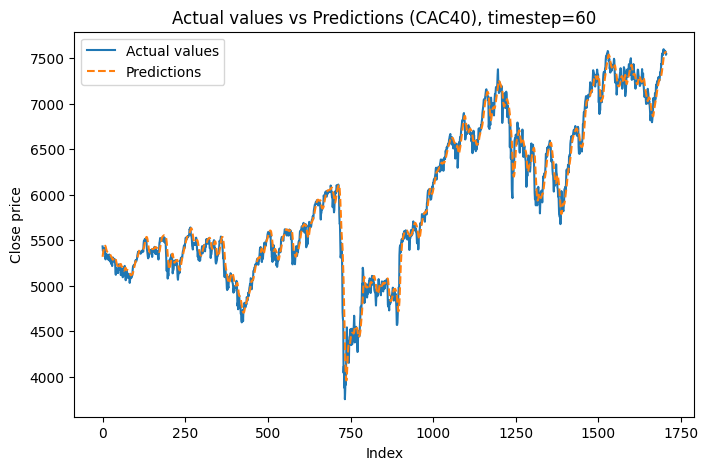

In [ ]:
true_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisation des vraies valeurs vs prédictions
plt.figure(figsize=(8, 5))
plt.plot(true_values, label="Actual values")
plt.plot(predictions, label="Predictions", linestyle="--")
plt.title("Actual values vs Predictions (CAC40), timestep=60")
plt.xlabel("Index")
plt.ylabel("Close price")
plt.legend()
plt.show()


Affichage des métriques d'erreur

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [ ]:
# Calcul des métriques
r2 = r2_score(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, predictions)

# Afficher les résultats
print(f"R2 score : {r2}")
print(f"Mean Squared Error (MSE) : {mse}")
print(f"Root Mean Squared Error (RMSE) : {rmse}")
print(f"Mean Absolute Error (MAE) : {mae}")


R2 score : 0.9799845914609255
Mean Squared Error (MSE) : 13977.740226493808
Root Mean Squared Error (RMSE) : 118.22749353045512
Mean Absolute Error (MAE) : 79.97318646161527


La partie qui suit était simplement pour vérifier si les performances changeaint beaucoup si on divisait le jeu de données en 3 (entrainement, validation, test) et non en 2 (entrainement, test).

PS: La réponse est non. Nous allons donc conserver la division en 2.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Une seule sortie pour prédire la prochaine valeur
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 0.0160 - val_loss: 4.5287e-04
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0013 - val_loss: 5.9428e-04
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - loss: 9.5708e-04 - val_loss: 5.4202e-04
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - loss: 8.2180e-04 - val_loss: 4.1825e-04
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 6.7347e-04 - val_loss: 3.8435e-04
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 6.3762e-04 - val_loss: 3.0331e-04
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 5.9338e-04 - val_loss: 3.0730e-04
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 5.3210e-04 - val_loss: 2.8841e-04
Epoch 9/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - loss: 5.3819e-04 - val_loss: 2.9695e-04
Epoch 10/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 5.4904e-04 - val_loss: 3.7744e-04
Epoch 11/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 65

In [ ]:
# Faire des prédictions
y_pred = model.predict(x_test)

# Inverser la normalisation pour interprétation
y_test_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(selected_features) - 1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), len(selected_features) - 1)), y_pred], axis=1))[:, -1]


54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 930ms/step


In [ ]:
# Évaluer les performances
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")


RMSE: 121.0737246473147
R2 Score: 0.9790092817108551


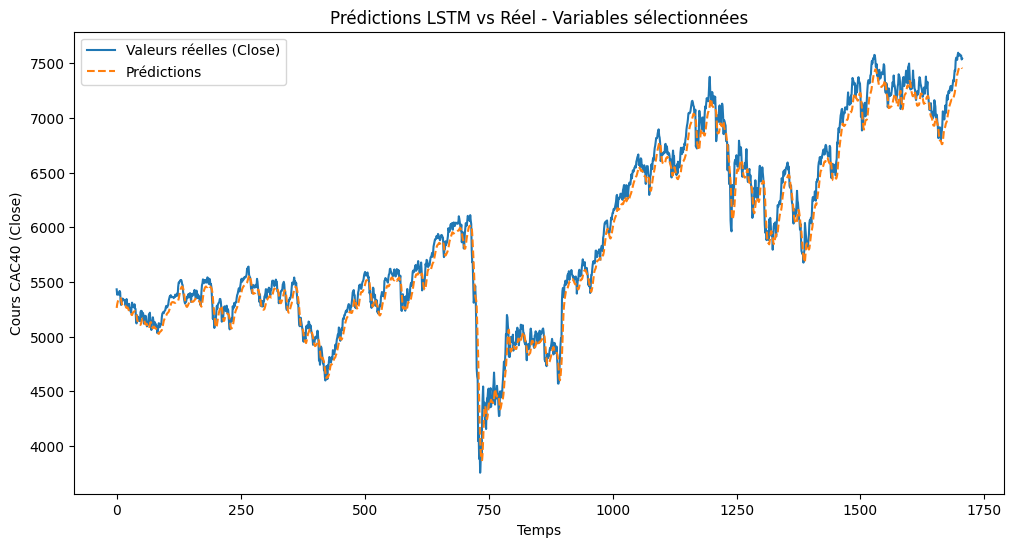

In [ ]:
# Visualiser les résultats
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Valeurs réelles (Close)")
plt.plot(y_pred_rescaled, label="Prédictions", linestyle='dashed')
plt.title("Prédictions LSTM vs Réel - Variables sélectionnées")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40 (Close)")
plt.legend()
plt.show()

In [ ]:
# séquences de taille 150

SEQ_LENGTH = 150
x, y = create_sequences(scaled_prices, SEQ_LENGTH)


In [ ]:
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Vérification des dimensions
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")


x_train shape: (6824, 60, 1), x_test shape: (1706, 60, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Une seule sortie pour prédire la prochaine valeur
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 0.0166 - val_loss: 8.5630e-04
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - loss: 0.0012 - val_loss: 7.1889e-04
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - loss: 9.5795e-04 - val_loss: 0.0014
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 8.3054e-04 - val_loss: 5.9324e-04
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 6.4340e-04 - val_loss: 5.0057e-04
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 6.1541e-04 - val_loss: 4.6779e-04
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 5.5718e-04 - val_loss: 4.4640e-04
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - loss: 5.4434e-04 - val_loss: 4.5367e-04
Epoch 9/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 5.1261e-04 - val_loss: 4.6655e-04
Epoch 10/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - loss: 5.3746e-04 - val_loss: 3.8341e-04


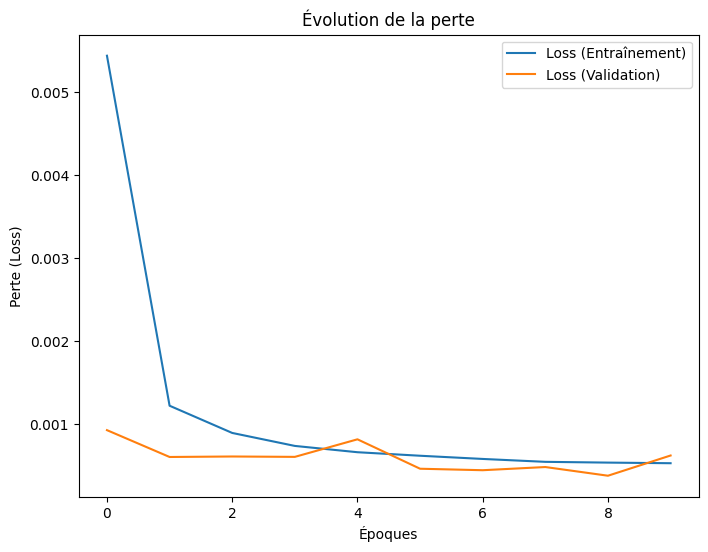

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # Remettre à l'échelle d'origine


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


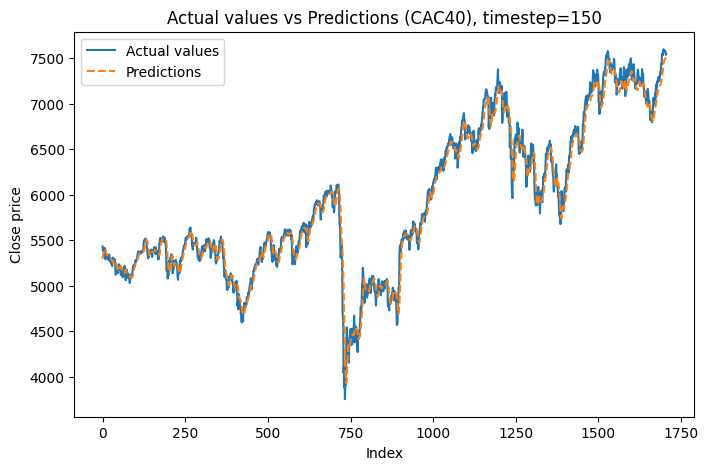

In [ ]:
true_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisation des vraies valeurs vs prédictions
plt.figure(figsize=(8, 5))
plt.plot(true_values, label="Actual values")
plt.plot(predictions, label="Predictions", linestyle="--")
plt.title("Actual values vs Predictions (CAC40), timestep=150")
plt.xlabel("Index")
plt.ylabel("Close price")
plt.legend()
plt.show()


Métriques d'erreur

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [ ]:
# Calcul des métriques
r2 = r2_score(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, predictions)

# Afficher les résultats
print(f"R2 score : {r2}")
print(f"Mean Squared Error (MSE) : {mse}")
print(f"Root Mean Squared Error (RMSE) : {rmse}")
print(f"Mean Absolute Error (MAE) : {mae}")


R2 score : 0.9791946846452726
Mean Squared Error (MSE) : 14529.370849010396
Root Mean Squared Error (RMSE) : 120.5378399051949
Mean Absolute Error (MAE) : 85.8302687435888


## LSTM: étude avec données complémentaires

A présent, nous allons inclure dans les données d'apprentissage des données macro économiques décrites dans le rapport plus en détails, au delà de la simple étude temporelle. Il s'agit de voir si l'ajout de ces données améliore les performances (qui sont déjà très bien, voir indiquent peut-être que le modèle est trop ajusté, même si c'est observé sur les données test).

In [ ]:
# Importation des données

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Charger le fichier CSV
data = pd.read_csv("eco_data_daily_clean.csv")

# Vérifier les données
print(data.head())
print(data.info())



         DATE          GDPV       IRL       IRS           GDP  CPIH_YTYPCT  \
0  2000-01-03  1.922807e+12  5.578081  3.558156  1.447856e+12     1.567372   
1  2000-01-04  1.923032e+12  5.576022  3.566075  1.448057e+12     1.566982   
2  2000-01-05  1.923257e+12  5.573963  3.573995  1.448258e+12     1.566592   
3  2000-01-06  1.923482e+12  5.571903  3.581915  1.448459e+12     1.566202   
4  2000-01-07  1.923707e+12  5.569844  3.589835  1.448660e+12     1.565812   

       IRCB       UNR           YPH    UNR_us  IRCB_us    CPI_us        CAC40  
0  2.516484  9.098174  4.838564e+11  4.047578      NaN  0.694063  5917.370117  
1  2.524725  9.093994  4.839066e+11  4.046468      NaN  0.694122  5672.020020  
2  2.532967  9.089814  4.839568e+11  4.045357      NaN  0.694182  5479.700195  
3  2.541209  9.085634  4.840070e+11  4.044247      NaN  0.694242  5450.109863  
4  2.549451  9.081453  4.840572e+11  4.043137      NaN  0.694302  5539.609863  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6

In [ ]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)


On veut voir s'il y a des données manquantes, et si oui, pour quelles variables.

In [ ]:
print(data.isnull().sum())

GDPV             0
IRL              0
IRS              0
GDP              0
CPIH_YTYPCT      0
IRCB             0
UNR              0
YPH              0
UNR_us           0
IRCB_us        886
CPI_us           0
CAC40            0
dtype: int64


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6348 entries, 2000-01-03 to 2024-10-30
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GDPV         6348 non-null   float64
 1   IRL          6348 non-null   float64
 2   IRS          6348 non-null   float64
 3   GDP          6348 non-null   float64
 4   CPIH_YTYPCT  6348 non-null   float64
 5   IRCB         6348 non-null   float64
 6   UNR          6348 non-null   float64
 7   YPH          6348 non-null   float64
 8   UNR_us       6348 non-null   float64
 9   IRCB_us      5462 non-null   float64
 10  CPI_us       6348 non-null   float64
 11  CAC40        6348 non-null   float64
dtypes: float64(12)
memory usage: 644.7 KB
None


In [ ]:
print(data.shape)

(6348, 12)


On va imputer les valeurs manquantes dans IRCB_us avec un imputer KNN

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
# Vérifier les colonnes contenant des NaN
print("Valeurs manquantes avant imputation :\n", data.isnull().sum())

Valeurs manquantes avant imputation :
 GDPV             0
IRL              0
IRS              0
GDP              0
CPIH_YTYPCT      0
IRCB             0
UNR              0
YPH              0
UNR_us           0
IRCB_us        886
CPI_us           0
CAC40            0
dtype: int64


In [ ]:
temp = data

In [ ]:
import pandas as pd

In [ ]:
# Sélectionner les colonnes numériques
numerical_features = temp.select_dtypes(include=['float64', 'int64']).columns

# Initialiser l'imputeur KNN
imputer = KNNImputer(n_neighbors=5, weights="uniform")  # "distance" peut aussi être testé

# Appliquer l'imputation
imputed_data = imputer.fit_transform(temp[numerical_features])  # ca retourne un ndarray


In [ ]:
imputed_data

array([[1.92280724e+12, 5.57808132e+00, 3.55815566e+00, ...,
        1.00000000e+00, 6.94062541e-01, 5.91737012e+03],
       [1.92303205e+12, 5.57602198e+00, 3.56607545e+00, ...,
        1.00000000e+00, 6.94122315e-01, 5.67202002e+03],
       [1.92325687e+12, 5.57396264e+00, 3.57399523e+00, ...,
        1.00000000e+00, 6.94182090e-01, 5.47970020e+03],
       ...,
       [2.60700607e+12, 2.99940455e+00, 2.98200753e+00, ...,
        4.55663043e+00, 1.29251101e+00, 7.55693994e+03],
       [2.60706996e+12, 2.99831760e+00, 2.97929014e+00, ...,
        4.55391304e+00, 1.29260300e+00, 7.51110986e+03],
       [2.60713385e+12, 2.99723064e+00, 2.97657275e+00, ...,
        4.55119565e+00, 1.29269499e+00, 7.42835986e+03]])

In [ ]:

# Convertir le résultat en DataFrame avec les noms de colonnes
temp[numerical_features] = pd.DataFrame(imputed_data, columns=numerical_features, index=temp.index)

In [ ]:
temp

GDPV       IRL       IRS           GDP  CPIH_YTYPCT  \
DATE                                                                      
2000-01-03  1.922807e+12  5.578081  3.558156  1.447856e+12     1.567372   
2000-01-04  1.923032e+12  5.576022  3.566075  1.448057e+12     1.566982   
2000-01-05  1.923257e+12  5.573963  3.573995  1.448258e+12     1.566592   
2000-01-06  1.923482e+12  5.571903  3.581915  1.448459e+12     1.566202   
2000-01-07  1.923707e+12  5.569844  3.589835  1.448660e+12     1.565812   
...                  ...       ...       ...           ...          ...   
2024-10-24  2.606751e+12  3.003752  2.992877  2.966591e+12     2.012639   
2024-10-25  2.606814e+12  3.002665  2.990160  2.966774e+12     2.011326   
2024-10-28  2.607006e+12  2.999405  2.982008  2.967323e+12     2.007388   
2024-10-29  2.607070e+12  2.998318  2.979290  2.967506e+12     2.006075   
2024-10-30  2.607134e+12  2.997231  2.976573  2.967689e+12     2.004762   

                IRCB       UNR           YPH    UNR_us   IRCB_us    CPI_us  \
DATE                                                                         
2000-01-03  2.516484  9.098174  4.838564e+11  4.047578  1.000000  0.694063   
2000-01-04  2.524725  9.093994  4.839066e+11  4.046468  1.000000  0.694122   
2000-01-05  2.532967  9.089814  4.839568e+11  4.045357  1.000000  0.694182   
2000-01-06  2.541209  9.085634  4.840070e+11  4.044247  1.000000  0.694242   
2000-01-07  2.549451  9.081453  4.840572e+11  4.043137  1.000000  0.694302   
...              ...       ...           ...       ...       ...       ...   
2024-10-24  2.937500  7.446300  1.010765e+12  4.161497  4.567500  1.292143   
2024-10-25  2.934783  7.448313  1.010840e+12  4.161385  4.564783  1.292235   
2024-10-28  2.926630  7.454352  1.011064e+12  4.161049  4.556630  1.292511   
2024-10-29  2.923913  7.456365  1.011138e+12  4.160936  4.553913  1.292603   
2024-10-30  2.921196  7.458379  1.011213e+12  4.160824  4.551196  1.292695   

                  CAC40  
DATE                     
2000-01-03  5917.370117  
2000-01-04  5672.020020  
2000-01-05  5479.700195  
2000-01-06  5450.109863  
2000-01-07  5539.609863  
...                 ...  
2024-10-24  7503.279785  
2024-10-25  7497.540039  
2024-10-28  7556.939941  
2024-10-29  7511.109863  
2024-10-30  7428.359863  

[6348 rows x 12 columns]

In [ ]:
# Vérifier les valeurs manquantes après imputation
print("Valeurs manquantes après imputation :\n", temp.isnull().sum())

Valeurs manquantes après imputation :
 GDPV           0
IRL            0
IRS            0
GDP            0
CPIH_YTYPCT    0
IRCB           0
UNR            0
YPH            0
UNR_us         0
IRCB_us        0
CPI_us         0
CAC40          0
dtype: int64


In [ ]:
print(temp['IRCB_us'].mean())

1.6035851456425552


L'im^putation a remplacé tous les na par des 1.. Après, la moyenne globale de IRCB_us est entre 1 et 2 donc ça ne change pas beaucoup. On ajustera certainement par la suite.

PS1: Avant de faire une imputation KNN, il fallait d'abord faire des tests de vérification sur le type de ces données manquantes. D'ailleurs, nous déciderons par la suite des les traiter différemment.

PS2: Tous les Nas se trouvent en début de table. Nous soupçonnons en fait que l'indicateur IRCB_us ne soit simplement pas collecté pendant cette période.

In [ ]:
data = temp

In [ ]:
data.head()

GDPV       IRL       IRS           GDP  CPIH_YTYPCT  \
DATE                                                                      
2000-01-03  1.922807e+12  5.578081  3.558156  1.447856e+12     1.567372   
2000-01-04  1.923032e+12  5.576022  3.566075  1.448057e+12     1.566982   
2000-01-05  1.923257e+12  5.573963  3.573995  1.448258e+12     1.566592   
2000-01-06  1.923482e+12  5.571903  3.581915  1.448459e+12     1.566202   
2000-01-07  1.923707e+12  5.569844  3.589835  1.448660e+12     1.565812   

                IRCB       UNR           YPH    UNR_us  IRCB_us    CPI_us  \
DATE                                                                        
2000-01-03  2.516484  9.098174  4.838564e+11  4.047578      1.0  0.694063   
2000-01-04  2.524725  9.093994  4.839066e+11  4.046468      1.0  0.694122   
2000-01-05  2.532967  9.089814  4.839568e+11  4.045357      1.0  0.694182   
2000-01-06  2.541209  9.085634  4.840070e+11  4.044247      1.0  0.694242   
2000-01-07  2.549451  9.081453  4.840572e+11  4.043137      1.0  0.694302   

                  CAC40  
DATE                     
2000-01-03  5917.370117  
2000-01-04  5672.020020  
2000-01-05  5479.700195  
2000-01-06  5450.109863  
2000-01-07  5539.609863

In [ ]:
import numpy as np
import pandas as pd

# Paramètres
lookback = 30  # nombre de jours dans chaque séquence

In [ ]:
# le prix de cloture est en dernière colonne

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :-1])  # Toutes les colonnes sauf la cible (CAC40)
        y.append(data[i+lookback, -1])    # La cible est CAC40
    return np.array(X), np.array(y)

# Charger les données nettoyées
data_narray = data.values  # Convertir le DataFrame en numpy array
X, y = create_sequences(data_narray, lookback)

# Diviser en ensembles d'entraînement et de test
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Forme des données d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Forme des données de test : {X_test.shape}, {y_test.shape}")


Forme des données d'entraînement : (5054, 30, 11), (5054,)
Forme des données de test : (1264, 30, 11), (1264,)


Nous avions oublié de normaliser avant ...

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normaliser toutes les colonnes
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# les séquences
X, y = create_sequences(data_scaled, lookback)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Données normalisées - X_train : {X_train.shape}, y_train : {y_train.shape}")


Données normalisées - X_train : (5054, 30, 11), y_train : (5054,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40
])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 30, 50)              │          12,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,901 (132.43 KB)

 Trainable params: 33,901 (132.43 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)


Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0270 - val_loss: 0.0201
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0044 - val_loss: 0.0287
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0034 - val_loss: 0.0306
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0031 - val_loss: 0.0319
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0027 - val_loss: 0.0290
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0026 - val_loss: 0.0266
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0022 - val_loss: 0.0231
Epoch 8/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0023 - val_loss: 0.0258
Epoch 9/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0022 - val_loss: 0.0233
Epoch 10/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0021 - val_loss: 0.0188
Epoch 11/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0020 - val_loss: 0.0206
Epoch 12/15
158/158 ━━━━━━━━━━━━━━━━

In [ ]:
#prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


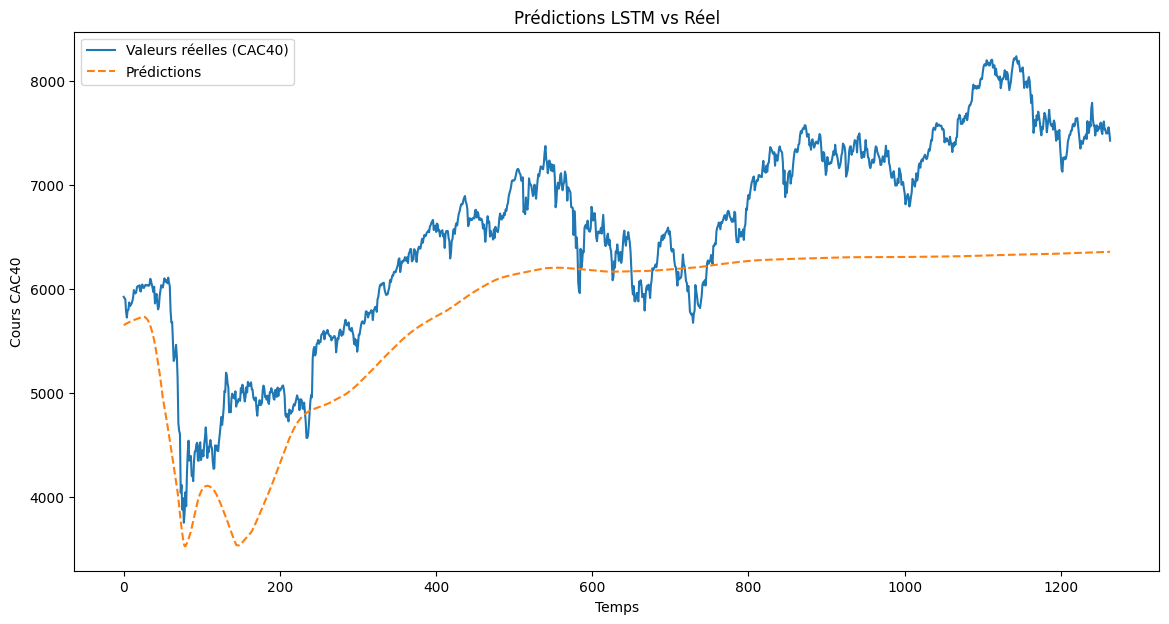

Erreur quadratique moyenne (MSE) : 808162.6827890463
Erreur absolue moyenne (MAE) : 789.2832378370067
Coefficient de détermination (R²) : 0.13094007770651706


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


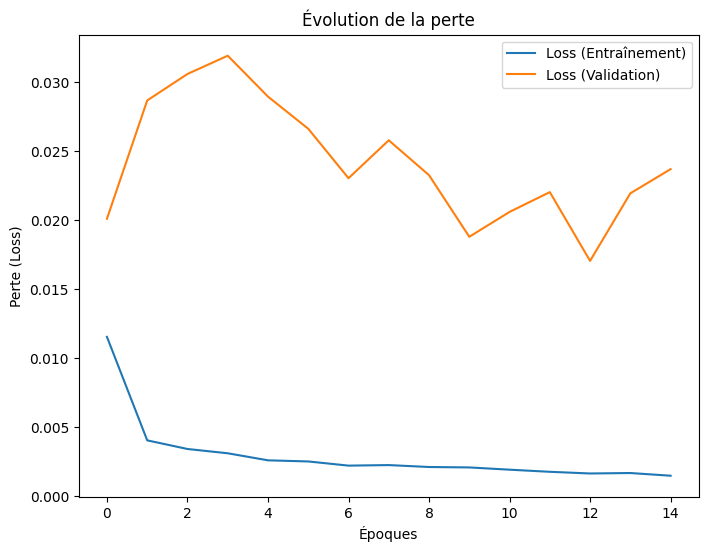

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


Plusieurs essais sont faits avec cette configuration, en changeant le nombre d'epochs. La tendance arrive globalement à être bien suivie par le modèle mais les prédictions sont loin d'être exactes. le R2 est d'ailleurs faible (0.13) et le MAE très elevé. On faisait beaucoup mieux avec un LSTM tout court, sans données macro.

Maintenant, on va essayer de modifier le taux d'apprentissage.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40
])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 30, 50)              │          12,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,901 (132.43 KB)

 Trainable params: 33,901 (132.43 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Définir l'optimiseur avec un taux d'apprentissage personnalisé
learning_rate = 0.0001  # on réduit le taux d'apprentissage et on garde le mm nombre d'epochs pour voir si ça s'améliore
optimizer = Adam(learning_rate=learning_rate)


In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)


Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0075 - val_loss: 0.0429
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0059 - val_loss: 0.0251
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0052 - val_loss: 0.0282
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0049 - val_loss: 0.0214
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0043 - val_loss: 0.0173
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0041 - val_loss: 0.0210
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0038 - val_loss: 0.0189
Epoch 8/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0036 - val_loss: 0.0246
Epoch 9/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0033 - val_loss: 0.0202
Epoch 10/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0032 - val_loss: 0.0175
Epoch 11/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0031 - val_loss: 0.0216
Epoch 12/15
158/158 ━━━━━━━━━━━━━━━━

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


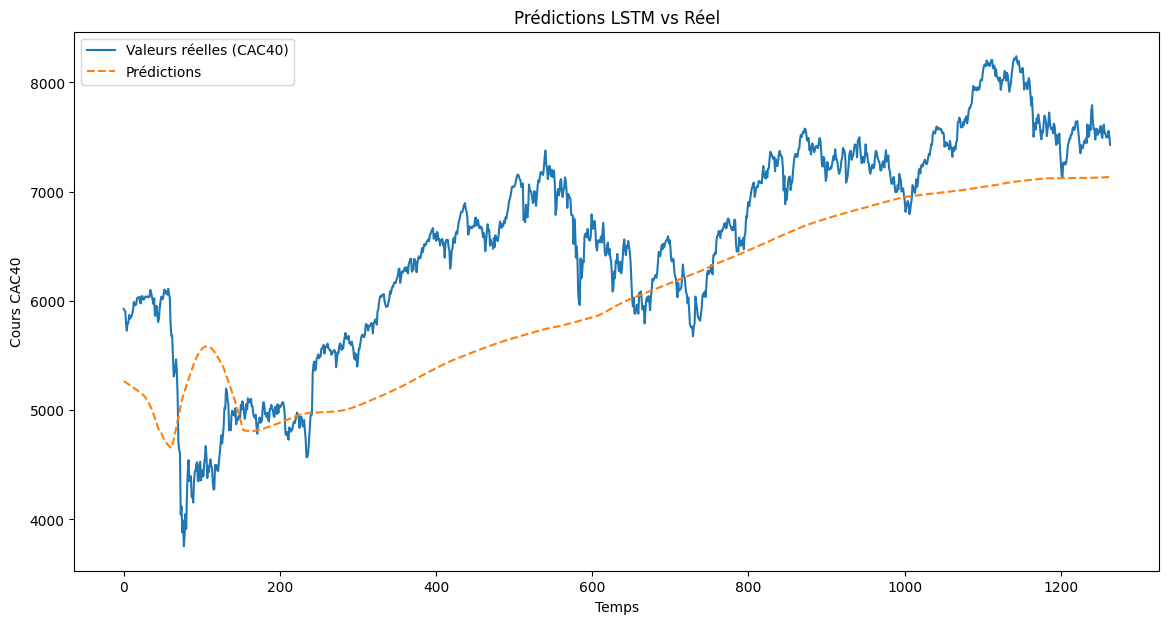

Erreur quadratique moyenne (MSE) : 557518.0771780495
Erreur absolue moyenne (MAE) : 634.7396056115955
Coefficient de détermination (R²) : 0.4004714308789231


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


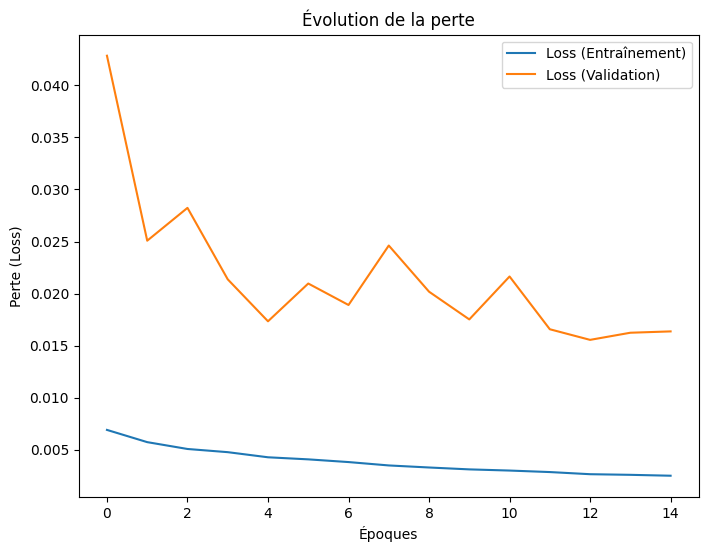

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


En faisant passer le taux d'apprentissage de 0.001 à 0.0001, le r2_score s'améliore de façon notable (40%) et le MAE diminue. Cependant, en observant le graphique, le modèle prédit moins bien l'évolution de la tendance globale.

Est-ce qu'en augmentant le nombre d'epochs, ca s'améliore ?

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40
])

# Résumé du modèle
model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

# Définir l'optimiseur avec un taux d'apprentissage personnalisé
learning_rate = 0.0001  # on réduit le taux d'apprentissage et on garde le mm nombre d'epochs pour voir si ça s'améliore
optimizer = Adam(learning_rate=learning_rate)


In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32)


Epoch 1/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0025 - val_loss: 0.0155
Epoch 2/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0023 - val_loss: 0.0215
Epoch 3/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0024 - val_loss: 0.0185
Epoch 4/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0022 - val_loss: 0.0182
Epoch 5/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0022 - val_loss: 0.0189
Epoch 6/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0022 - val_loss: 0.0159
Epoch 7/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0022 - val_loss: 0.0148
Epoch 8/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0021 - val_loss: 0.0156
Epoch 9/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0021 - val_loss: 0.0160
Epoch 10/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0020 - val_loss: 0.0151
Epoch 11/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0020 - val_loss: 0.0186
Epoch 12/40
158/158 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


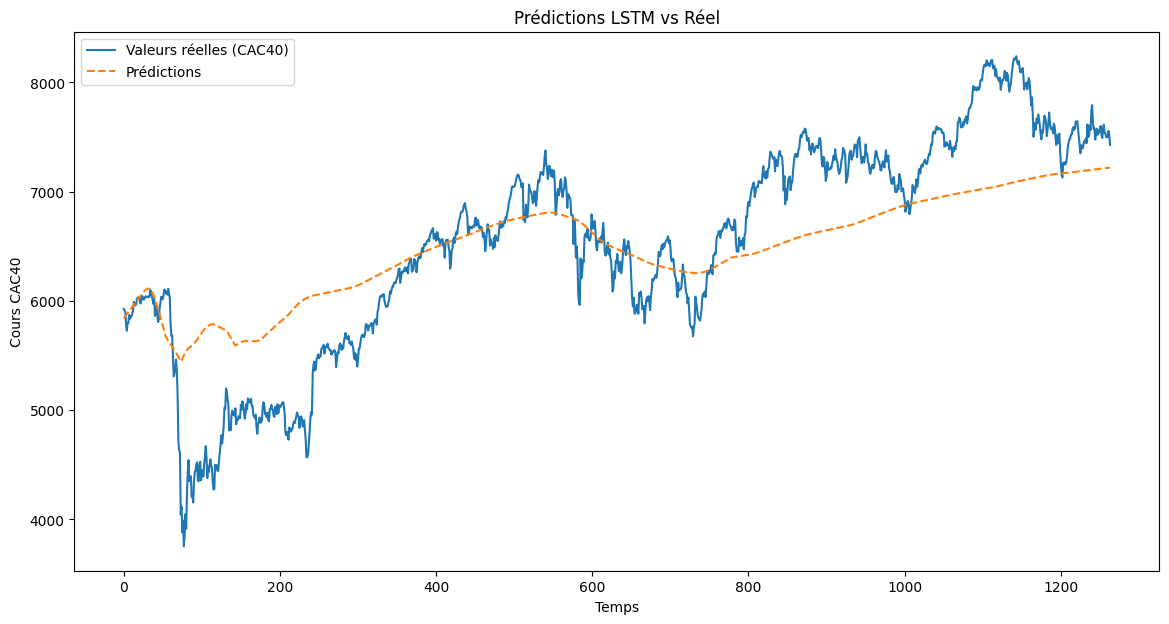

Erreur quadratique moyenne (MSE) : 333926.85421396035
Erreur absolue moyenne (MAE) : 457.1795697088611
Coefficient de détermination (R²) : 0.640910856000706


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


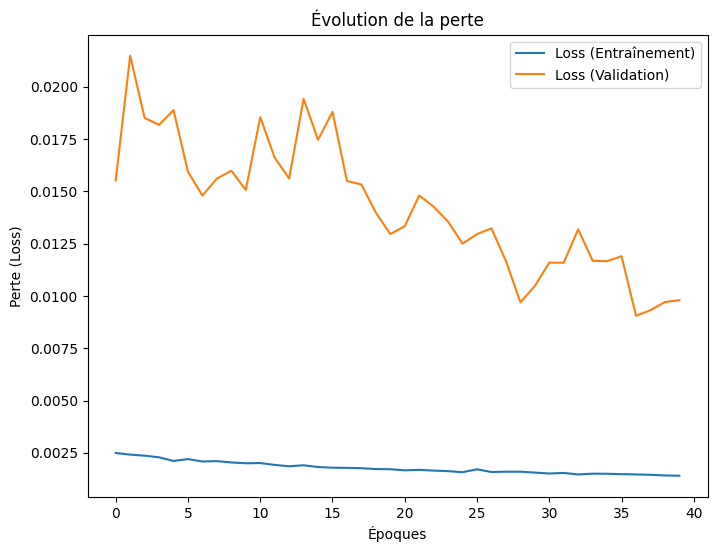

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


Les performances s'améliorent légèrement. Nous allons augmenter encore le nombre d'epochs.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40
])

# Résumé du modèle
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 30, 50)              │          12,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,901 (132.43 KB)

 Trainable params: 33,901 (132.43 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Définir l'optimiseur avec un taux d'apprentissage personnalisé
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)


In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=32)


Epoch 1/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0657 - val_loss: 0.0687
Epoch 2/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0101 - val_loss: 0.0537
Epoch 3/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0073 - val_loss: 0.0522
Epoch 4/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0061 - val_loss: 0.0463
Epoch 5/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0056 - val_loss: 0.0397
Epoch 6/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0052 - val_loss: 0.0388
Epoch 7/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0050 - val_loss: 0.0380
Epoch 8/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0047 - val_loss: 0.0327
Epoch 9/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0045 - val_loss: 0.0299
Epoch 10/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0043 - val_loss: 0.0304
Epoch 11/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0039 - val_loss: 0.0273
Epoch 12/70
158/158 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


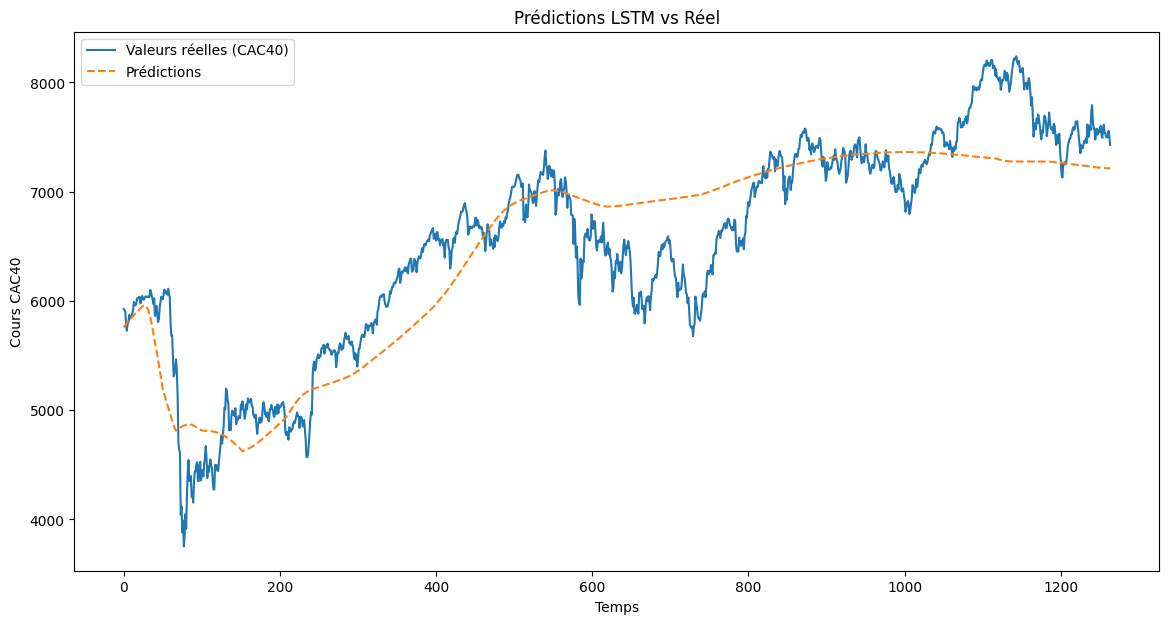

Erreur quadratique moyenne (MSE) : 197352.68696321768
Erreur absolue moyenne (MAE) : 355.93387267665736
Coefficient de détermination (R²) : 0.7877762553886277


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


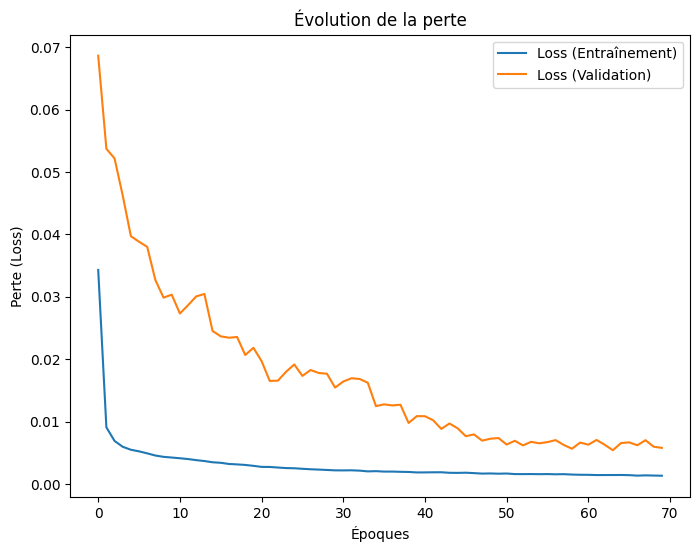

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


Le R2 et le MAE s'améliorent de façon notable. De plus, la perte sur l'ensemble de validation semble continuer de baisser. Nous augmentons donc une nouvelle fois le nombre d'epochs pour voir les possibles améliorations que nous pouvons en tirer.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40
])

# Résumé du modèle
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 30, 50)              │          12,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,901 (132.43 KB)

 Trainable params: 33,901 (132.43 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Définir l'optimiseur avec un taux d'apprentissage personnalisé
learning_rate = 0.0001  # on réduit le taux d'apprentissage et on garde le mm nombre d'epochs pour voir si ça s'améliore
optimizer = Adam(learning_rate=learning_rate)


In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)


Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 0.0332 - val_loss: 0.1107
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0091 - val_loss: 0.0675
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0067 - val_loss: 0.0507
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0060 - val_loss: 0.0495
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0055 - val_loss: 0.0525
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0050 - val_loss: 0.0521
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0049 - val_loss: 0.0502
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0045 - val_loss: 0.0473
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0041 - val_loss: 0.0410
Epoch 10/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0040 - val_loss: 0.0430
Epoch 11/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0039 - val_loss: 0.0404
Epoch 12/100
158/158 ━━

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


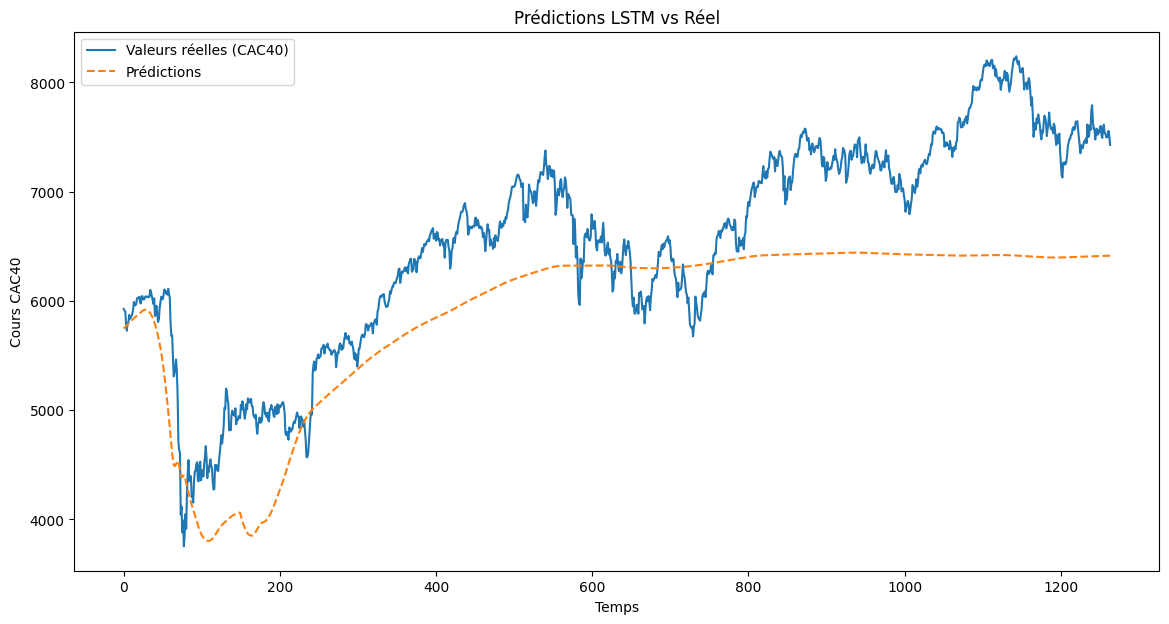

Erreur quadratique moyenne (MSE) : 639583.0340122664
Erreur absolue moyenne (MAE) : 683.333794777228
Coefficient de détermination (R²) : 0.31222265804121585


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


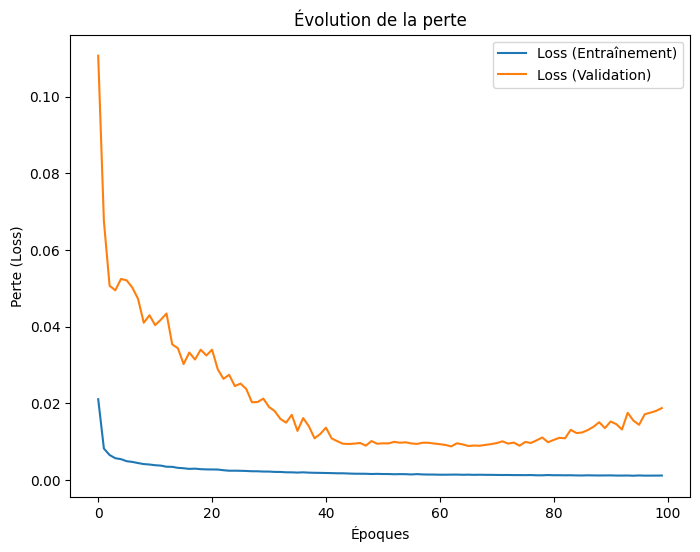

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


Nous avons dépasser le bon nombre d'epochs qu'il fallait choisir. Il est visible de façon claire sur le graphique que nous commençons a faire du surapprentissage.

Maintenant, nous allons travailler avec une base de données plus complète, contenant plus d'indicateurs et refaire les tests.

On télécharge la base de données final_data.csv et on fait le même travail qu'au début.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Importation des données

data = pd.read_csv("../data/output/final_database.csv")

# Vérifier les données
print(data.head())
print(data.info())



         Date          GDPV       IRL       IRS           GDP  CPIH_YTYPCT  \
0  2000-01-03  1.922807e+12  5.578081  3.558156  1.447856e+12     1.567372   
1  2000-01-04  1.923032e+12  5.576022  3.566075  1.448057e+12     1.566982   
2  2000-01-05  1.923257e+12  5.573963  3.573995  1.448258e+12     1.566592   
3  2000-01-06  1.923482e+12  5.571903  3.581915  1.448459e+12     1.566202   
4  2000-01-07  1.923707e+12  5.569844  3.589835  1.448660e+12     1.565812   

       IRCB       UNR           YPH    UNR_us  ...        WMA_5       WMA_10  \
0  2.516484  9.098174  4.838564e+11  4.047578  ...  5876.351986  5799.456934   
1  2.524725  9.093994  4.839066e+11  4.046468  ...  5894.800684  5835.060405   
2  2.532967  9.089814  4.839568e+11  4.045357  ...  5827.141341  5818.509854   
3  2.541209  9.085634  4.840070e+11  4.044247  ...  5706.205404  5764.248242   
4  2.549451  9.081453  4.840572e+11  4.043137  ...  5598.564681  5705.507298   

        WMA_20    Momentum        RSI  Williams_R 

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [ ]:
print(data.isnull().sum())

GDPV                  0
IRL                   0
IRS                   0
GDP                   0
CPIH_YTYPCT           0
IRCB                  0
UNR                   0
YPH                   0
UNR_us                0
IRCB_us             886
CPI_us                0
Close                 0
Return                0
High_minus_Low        0
Close_minus_Open      0
SMA_5                 0
SMA_10                0
SMA_20                0
WMA_5                 0
WMA_10                0
WMA_20                0
Momentum              0
RSI                   0
Williams_R            0
Stochastic_K          0
Stochastic_D          0
CCI                   0
MACD                  0
dtype: int64


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6347 entries, 2000-01-03 to 2024-10-29
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GDPV              6347 non-null   float64
 1   IRL               6347 non-null   float64
 2   IRS               6347 non-null   float64
 3   GDP               6347 non-null   float64
 4   CPIH_YTYPCT       6347 non-null   float64
 5   IRCB              6347 non-null   float64
 6   UNR               6347 non-null   float64
 7   YPH               6347 non-null   float64
 8   UNR_us            6347 non-null   float64
 9   IRCB_us           5461 non-null   float64
 10  CPI_us            6347 non-null   float64
 11  Close             6347 non-null   float64
 12  Return            6347 non-null   float64
 13  High_minus_Low    6347 non-null   float64
 14  Close_minus_Open  6347 non-null   float64
 15  SMA_5             6347 non-null   float64
 16  SMA_10            6347 n

In [ ]:
print(data.shape)

(6347, 28)


Nous avons toujours les données manquantes pour IRCB_us.

Finalement, nous allons supprimer les lignes qui contiennent les valeurs manquantes pour IRCB_us, elles sont toutes en début de table: il ne s'agit propablement pas de "missing at random values". En imputant des valeurs, quelle que soit la méthode, on risque d'introduire du biais.

In [ ]:
# Supprimer les lignes contenant des valeurs manquantes uniquement pour la colonne 'IRCB_us'
data_cleaned = data.dropna(subset=['IRCB_us'])

# Vérifier les dimensions du DataFrame après la suppression
print(f"Taille des données avant suppression : {data.shape}")
print(f"Taille des données après suppression : {data_cleaned.shape}")

# Vérifier qu'il n'y a plus de valeurs manquantes dans 'IRCB_us'
print(data_cleaned['IRCB_us'].isnull().sum())


Taille des données avant suppression : (6347, 28)
Taille des données après suppression : (5461, 28)
0


In [ ]:
data = data_cleaned

In [ ]:
# on va déplacer la colonne cible en dernière position du dataframe pour réutiliser notre fonction de création de séquences

column_to_move = "Close"
cols = [col for col in data.columns if col != column_to_move]
data = data[cols + [column_to_move]]

# Vérifier que la colonne "Close" est bien en dernière position
print(data.columns)


Index(['GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR', 'YPH',
       'UNR_us', 'IRCB_us', 'CPI_us', 'Return', 'High_minus_Low',
       'Close_minus_Open', 'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10',
       'WMA_20', 'Momentum', 'RSI', 'Williams_R', 'Stochastic_K',
       'Stochastic_D', 'CCI', 'MACD', 'Close'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd

# Paramètres
lookback = 30  # Nombre de jours dans chaque séquence

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaled_data = scaler.fit_transform(data)

In [ ]:


def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :-1])  # Toutes les colonnes sauf la cible (Close)
        y.append(data[i+lookback, -1])    # La cible est Close
        print()
    return np.array(X), np.array(y)

# Charger les données nettoyées
data_narray = data.values  # Convertir le DataFrame en numpy array
X, y = create_sequences(data_narray, lookback)

# Diviser en ensembles d'entraînement et de test
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Forme des données d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Forme des données de test : {X_test.shape}, {y_test.shape}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
data.shape

(5461, 28)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normaliser toutes les colonnes
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Recréer les séquences avec les données normalisées
X, y = create_sequences(data_scaled, lookback)

# Diviser à nouveau en ensemble d'entraînement et de test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Vérifier les formes
print(f"Données normalisées - X_train : {X_train.shape}, y_train : {y_train.shape}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 30, 50)              │          15,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,101 (144.93 KB)

 Trainable params: 37,101 (144.93 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0219 - val_loss: 0.0236
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0048 - val_loss: 0.0135
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0033 - val_loss: 0.0131
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0027 - val_loss: 0.0139
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0024 - val_loss: 0.0135
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0020 - val_loss: 0.0108
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0019 - val_loss: 0.0128
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0017 - val_loss: 0.0100
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0016 - val_loss: 0.0092
Epoch 10/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0014 - val_loss: 0.0085
Epoch 11/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0013 - val_loss: 0.0123
Epoch 12/20
136/136 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


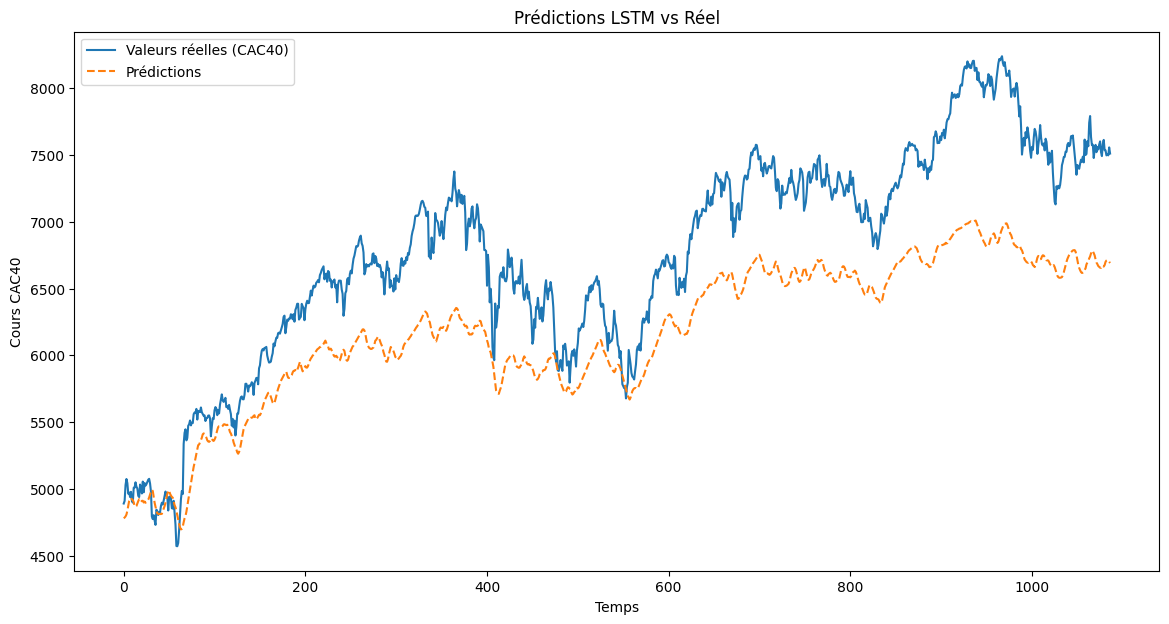

Erreur quadratique moyenne (MSE) : 420993.3327953834
Erreur absolue moyenne (MAE) : 582.8298950041991
Coefficient de détermination (R²) : 0.3545733585585257


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


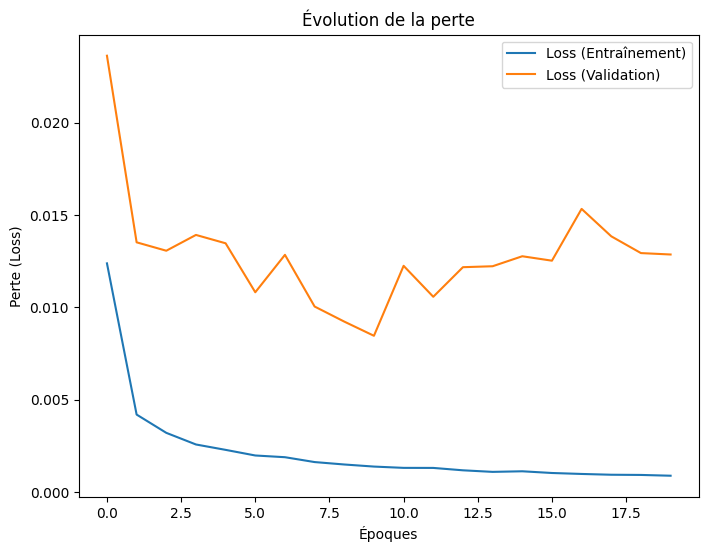

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


L'ajustement est mieux dans le sens où il est moins lissé, par contre le R2 global est plus faible. On va essayer d'augmenter le nombre de couches du réseau pour voir si l'apprentissage s'améliore, en conservant par ailleurs les autres hyperparamètres intacts.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    # on précise ici qu'il y a des séquences de données antérieures à prendre en compte (lookback)
    LSTM(100, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.3),
    LSTM(90, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 30, 100)             │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 90)                  │          68,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 90)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 25)                  │           2,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,261 (477.58 KB)

 Trainable params: 122,261 (477.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.1681 - val_loss: 0.3238
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0404 - val_loss: 0.1493
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0278 - val_loss: 0.0934
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0198 - val_loss: 0.0528
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0137 - val_loss: 0.0276
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0096 - val_loss: 0.0143
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.0083 - val_loss: 0.0095
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 10/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 11/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 12/20
136/136 ━━━━━━━━━━━━

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


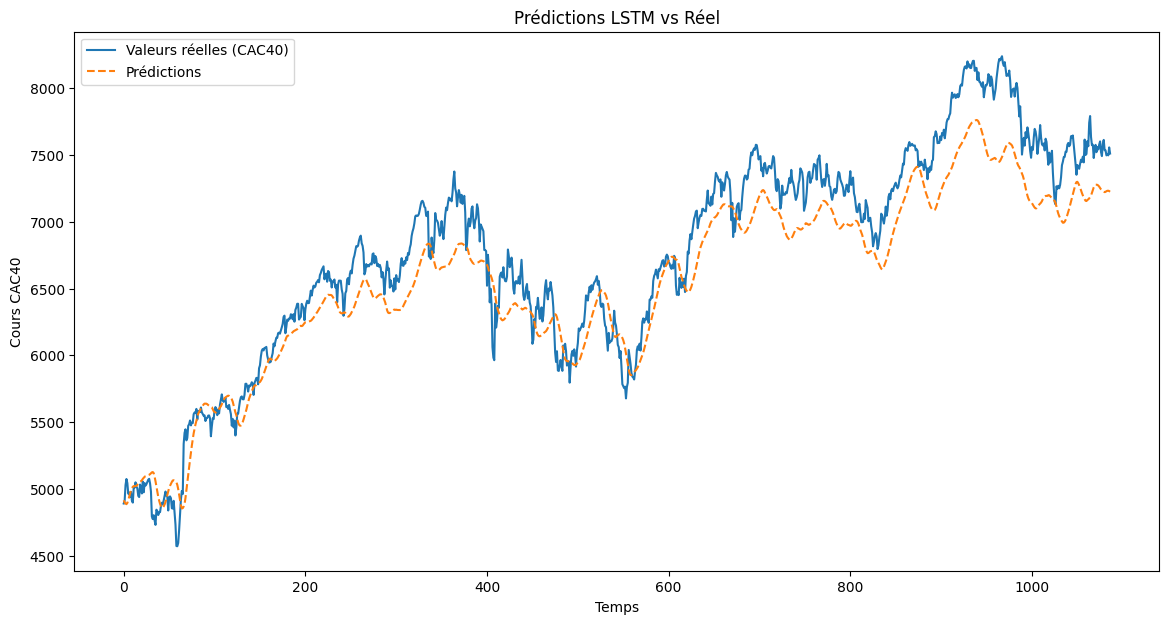

Erreur quadratique moyenne (MSE) : 81997.6245685928
Erreur absolue moyenne (MAE) : 243.53261927896017
Coefficient de détermination (R²) : 0.874289098404301


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


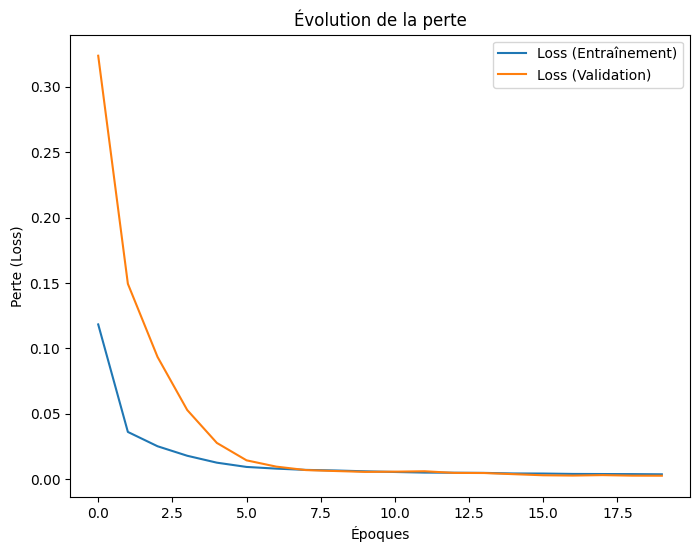

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


Les résultats obtenus commencent à être intéressants. Nous allons conserver la même approche, c'est-à-dire augmenter les taille de sortie des couches et constater s'il y a amélioration des performances ou non.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    # on précise ici qu'il y a des séquences de données antérieures à prendre en compte (lookback)
    LSTM(150, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

# Résumé du modèle
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 30, 150)             │         106,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 30, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 100)                 │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 25)                  │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,751 (819.34 KB)

 Trainable params: 209,751 (819.34 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)


Epoch 1/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - loss: 0.0927 - val_loss: 0.0618
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.0123 - val_loss: 0.0217
Epoch 3/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0090 - val_loss: 0.0124
Epoch 4/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 5/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 0.0060 - val_loss: 0.0067
Epoch 6/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 7/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 8/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 9/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 10/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 11/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 12/30
136/136 ━━━━━━━━━

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


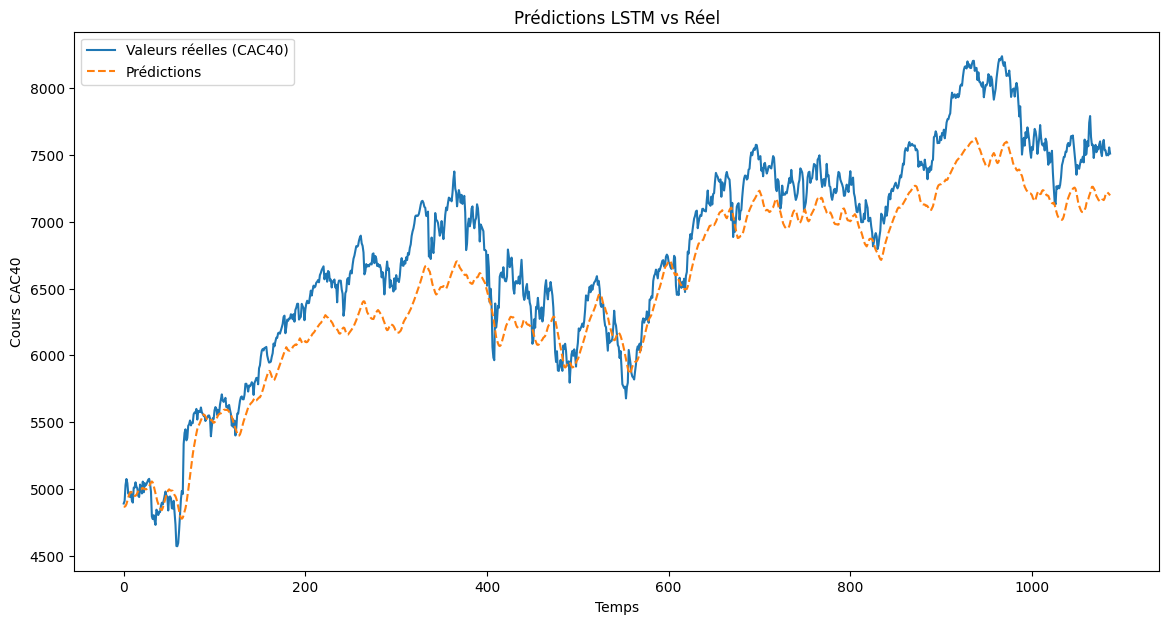

Erreur quadratique moyenne (MSE) : 102697.39486316901
Erreur absolue moyenne (MAE) : 275.3654705161415
Coefficient de détermination (R²) : 0.842554193884253


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


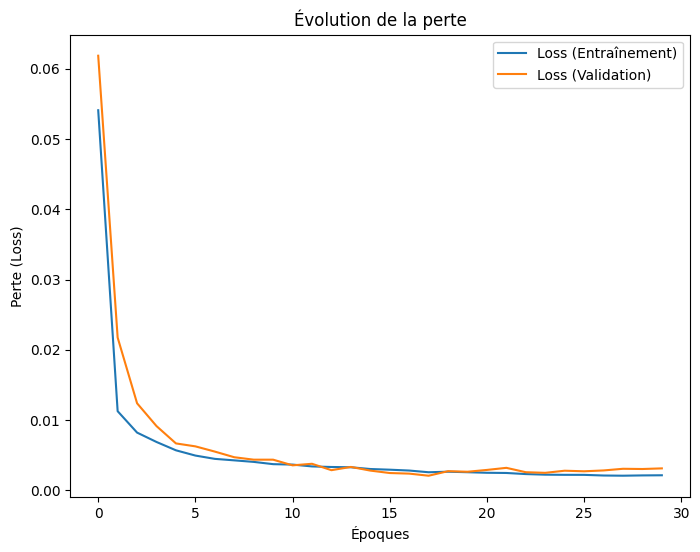

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    # on précise ici qu'il y a des séquences de données antérieures à prendre en compte (lookback)
    LSTM(300, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.3),
    LSTM(150, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                       │ (None, 30, 300)             │         393,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 30, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 150)                 │         270,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 25)                  │           3,775 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 668,001 (2.55 MB)

 Trainable params: 668,001 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)


Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - loss: 0.0307 - val_loss: 0.0156
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - loss: 0.0083 - val_loss: 0.0037
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 8/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 9/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 11/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 12/15
136/136

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step


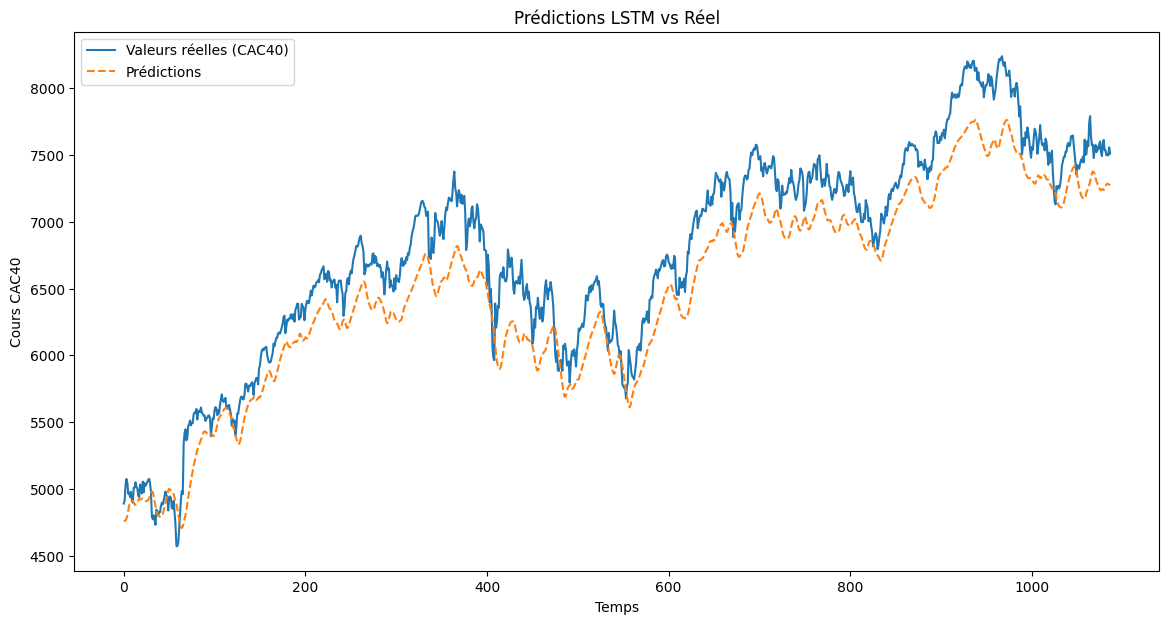

Erreur quadratique moyenne (MSE) : 95847.16694953591
Erreur absolue moyenne (MAE) : 278.18860157333296
Coefficient de détermination (R²) : 0.8530563069843523


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


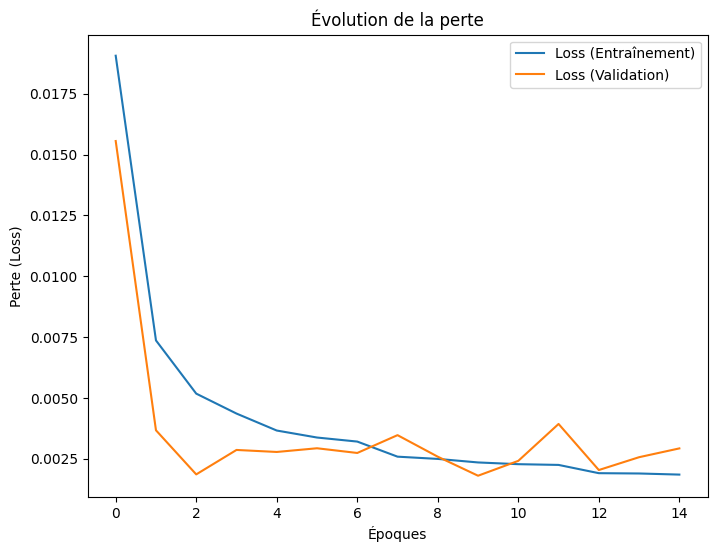

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    # on précise ici qu'il y a des séquences de données antérieures à prendre en compte (lookback)
    LSTM(400, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.3),
    LSTM(200, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 30, 400)             │         684,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 30, 400)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 200)                 │         480,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 25)                  │           5,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,170,651 (4.47 MB)

 Trainable params: 1,170,651 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - loss: 0.0500 - val_loss: 0.0112
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 44s 304ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 80s 292ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - loss: 0.0027 - val_loss: 9.6813e-04
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 299ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 291ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 294ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 10/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 287ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 11/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 12/20
136

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step


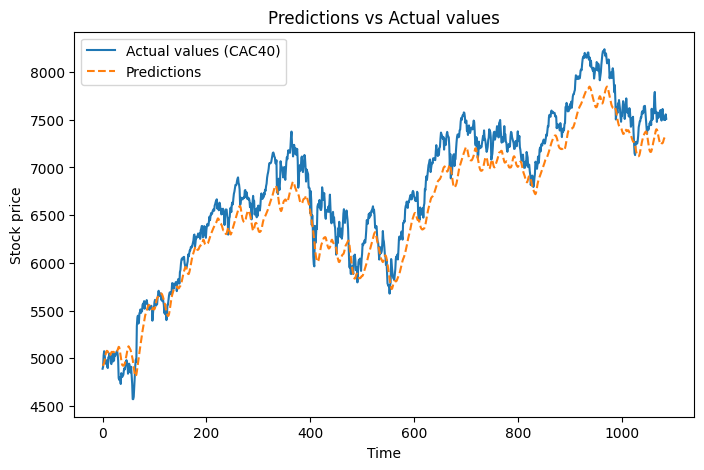

Erreur quadratique moyenne (MSE) : 70931.91136952072
Erreur absolue moyenne (MAE) : 233.14649087675502
Coefficient de détermination (R²) : 0.8912539896480847


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(8, 5))
plt.plot(y_test_actual, label='Actual values (CAC40)')
plt.plot(predictions_actual, label='Predictions', linestyle='dashed')
plt.title("Predictions vs Actual values")
plt.xlabel("Time")
plt.ylabel("Stock price")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


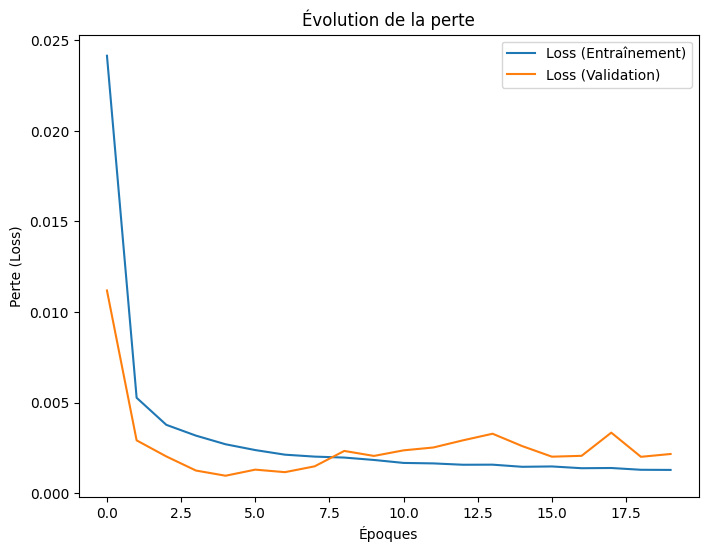

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


Bien sûr, plus on augmente ces tailles de sortie, plus le temps d'exécution s'allonge: il y a plus de paramètres dans le modèle.

Maintenant on va modifier le lookback, voir si il change beaucoup les performances. Il était à 30 précédemment.

In [ ]:
import numpy as np
import pandas as pd

# Paramètres
lookback = 100  # Nombre de jours dans chaque séquence

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaled_data = scaler.fit_transform(data)

In [ ]:
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :-1])  # Toutes les colonnes sauf la cible (Close)
        y.append(data[i+lookback, -1])    # La cible est Close
        print()
    return np.array(X), np.array(y)

# Charger les données nettoyées
data_narray = data.values  # Convertir le DataFrame en numpy array
X, y = create_sequences(data_narray, lookback)

# Diviser en ensembles d'entraînement et de test
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Forme des données d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Forme des données de test : {X_test.shape}, {y_test.shape}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
data.shape

(5461, 28)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normaliser toutes les colonnes
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Recréer les séquences avec les données normalisées
X, y = create_sequences(data_scaled, lookback)

# Diviser à nouveau en ensemble d'entraînement et de test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Vérifier les formes
print(f"Données normalisées - X_train : {X_train.shape}, y_train : {y_train.shape}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    LSTM(150, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100, 150)            │         106,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 150)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,751 (819.34 KB)

 Trainable params: 209,751 (819.34 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# on a fait des essais avec plusieurs valeurs de learning_rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 356ms/step - loss: 0.0146 - val_loss: 0.0043
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 76s 314ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 86s 347ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 395ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 47s 353ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 88s 401ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 75s 352ms/step - loss: 0.0011 - val_loss: 0.0065
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 320ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 298ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 43s 313ms/step - loss: 9.7682e-04 - val_loss: 0.0049
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 80s 302ms/step - loss: 9.9203e-04 - val_loss: 0.0043
Epoch 12/20

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step


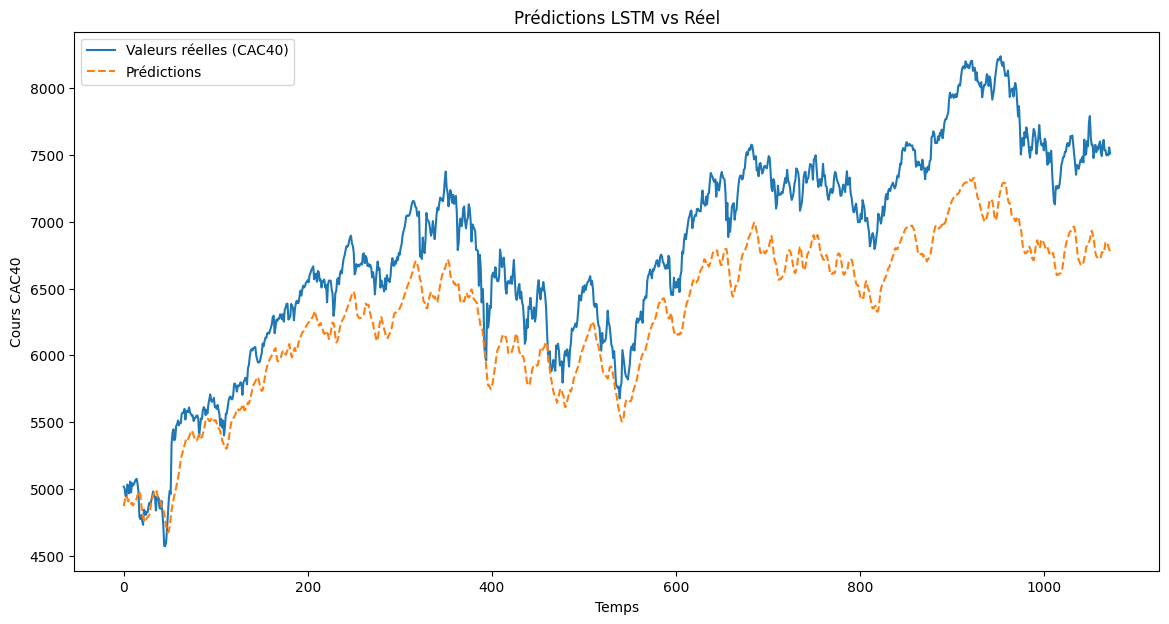

Erreur quadratique moyenne (MSE) : 277448.40678829624
Erreur absolue moyenne (MAE) : 473.6535350924011
Coefficient de détermination (R²) : 0.5519237091418613


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


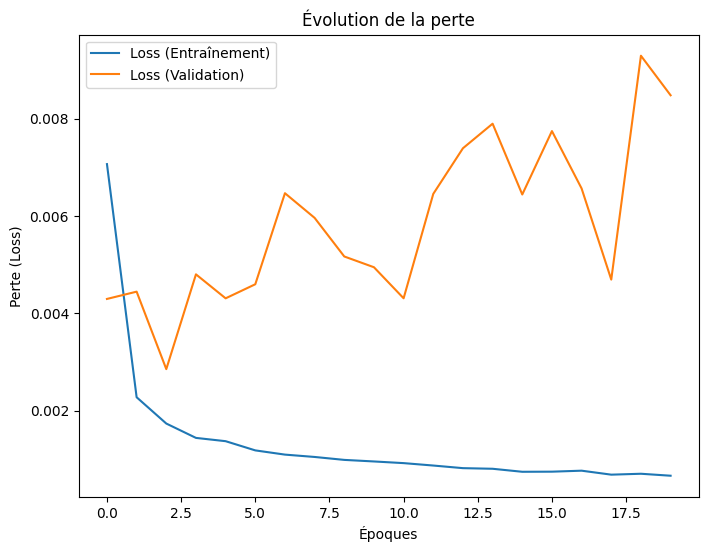

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


Les résultats sont moins bons. Ca confirme ce que l'on semblait aussi observer avec l'étude purement temporelle au début: le CAC40 semble être plus à court plutôt qu'à long terme.

Maintenant, nous allons reprendre nos implémentations mais en ne considérant que les 3 variables significatives qui ont été retenues avec le Gradient Boosting.

In [ ]:
# Filtrer uniquement les variables souhaitées
selected_features = ["UNR_us", "CPI_us", "UNR", "Close"]
data = data[selected_features]

# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Créer les séquences temporelles
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, -1])    # La colonne "Close"
    return np.array(X), np.array(y)

In [ ]:
# Paramètres
lookback = 30  # Taille de la fenêtre temporelle

# Diviser les données en ensemble d'entraînement et de test
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
X_train, y_train = create_sequences(train_data, lookback)
X_test, y_test = create_sequences(test_data, lookback)

In [ ]:
# Construire le modèle LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    LSTM(90, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Prédire la variable "Close"
])

# Résumé du modèle
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 30, 100)             │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 90)                  │          68,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 90)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 25)                  │           2,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,661 (440.08 KB)

 Trainable params: 112,661 (440.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
data.shape

(5461, 4)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [ ]:
# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 0.1048 - val_loss: 0.3982
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0450 - val_loss: 0.2711
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0345 - val_loss: 0.1795
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0285 - val_loss: 0.0906
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0216 - val_loss: 0.0338
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0175 - val_loss: 0.0109
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 0.0147 - val_loss: 0.0061
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0135 - val_loss: 0.0061
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0115 - val_loss: 0.0062
Epoch 10/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.0110 - val_loss: 0.0062
Epoch 11/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.0099 - val_loss: 0.0063
Epoch 12/20
136/136 ━━━━━━━━━━━━━━━

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


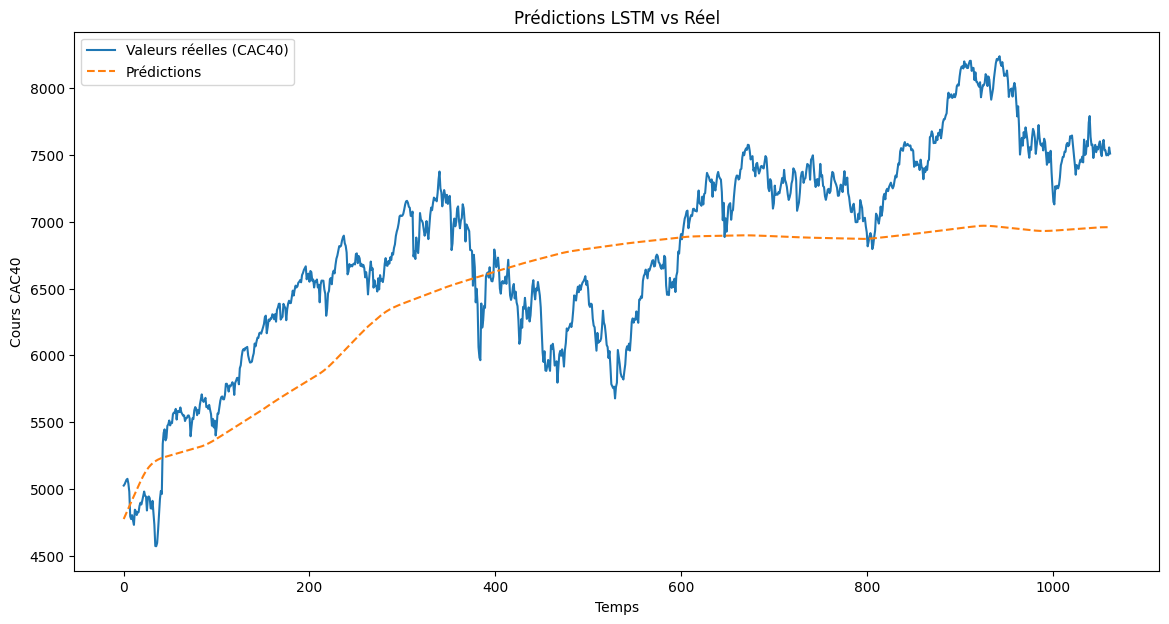

Erreur quadratique moyenne (MSE) : 322662.0502085613
Erreur absolue moyenne (MAE) : 498.36775337770393
Coefficient de détermination (R²) : 0.457830003929125


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


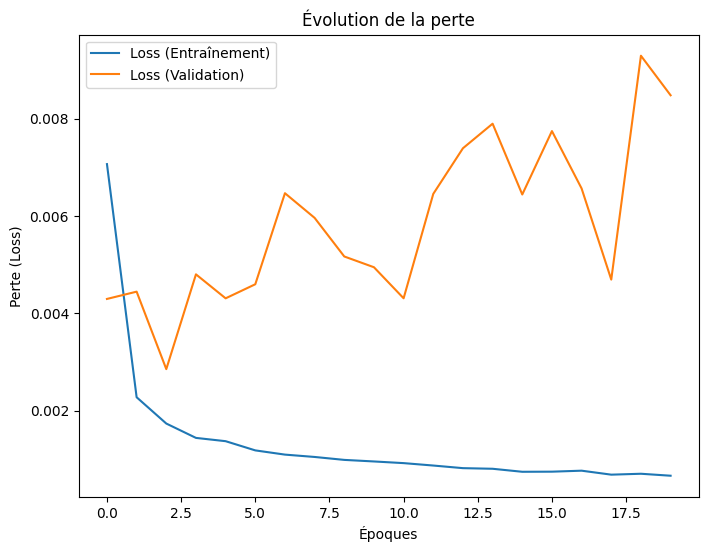

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


Les résultats avec les 3 variables choisies pour Gradient Boost ne sont pas satisfaisants (plusieurs valeurs d'hyperparamètres ont été testées), presque aussi mauvais voir plus mauvais que les premiers essais avec la table restreinte de données sur laquelle nous travaillions plus haut. Ca signifie qu'il y a des variables/indicateurs vraiment significatifs dans la table finale final_database qu'on ne retrouve pas dans l'autre, et qui permettent d'avoir de bonnes prévisions (qui permettent en particulier de modéliser les petits sauts des indices boursiers et de se débarasser du caractère lisse et pauvrement prédictif).

Maintenant, on va modifier légèrement les modèles précédents en rajoutant une couche LSTM, pour voir si ça s'améliore. Avant celà, on récupère la table entière avec laquelle nous avions de meilleurs résultats qu'avec la table réduite.

In [1]:
# Importation des données

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Charger le fichier CSV
data = pd.read_csv("../data/output/final_database.csv")

# Vérifier les données
print(data.head())
print(data.info())



         Date        Close    Return        SMA_5       SMA_10       SMA_20  \
0  2000-01-03  5917.370117 -0.006896  5862.024023  5721.551025  5620.770020   
1  2000-01-04  5672.020020 -0.042347  5874.998047  5763.048047  5643.236035   
2  2000-01-05  5479.700195 -0.034495  5842.508008  5778.139063  5651.338525   
3  2000-01-06  5450.109863 -0.005415  5773.032031  5773.185059  5648.598047   
4  2000-01-07  5539.609863  0.016288  5695.504004  5756.067041  5646.747534   

         WMA_5       WMA_10       WMA_20       MACD  ...       IRL       IRS  \
0  5876.351986  5799.456934  5691.589455  66.063532  ...  5.578081  3.558156   
1  5894.800684  5835.060405  5719.837084  71.222855  ...  5.576022  3.566075   
2  5827.141341  5818.509854  5722.578416  57.911439  ...  5.573963  3.573995   
3  5706.205404  5764.248242  5706.231908  33.835439  ...  5.571903  3.581915   
4  5598.564681  5705.507298  5687.328271  12.702531  ...  5.569844  3.589835   

            GDP  CPIH_YTYPCT      IRCB      

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [ ]:
print(data.isnull().sum())

GDPV                  0
IRL                   0
IRS                   0
GDP                   0
CPIH_YTYPCT           0
IRCB                  0
UNR                   0
YPH                   0
UNR_us                0
IRCB_us             886
CPI_us                0
Close                 0
Return                0
High_minus_Low        0
Close_minus_Open      0
SMA_5                 0
SMA_10                0
SMA_20                0
WMA_5                 0
WMA_10                0
WMA_20                0
Momentum              0
RSI                   0
Williams_R            0
Stochastic_K          0
Stochastic_D          0
CCI                   0
MACD                  0
dtype: int64


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6347 entries, 2000-01-03 to 2024-10-29
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GDPV              6347 non-null   float64
 1   IRL               6347 non-null   float64
 2   IRS               6347 non-null   float64
 3   GDP               6347 non-null   float64
 4   CPIH_YTYPCT       6347 non-null   float64
 5   IRCB              6347 non-null   float64
 6   UNR               6347 non-null   float64
 7   YPH               6347 non-null   float64
 8   UNR_us            6347 non-null   float64
 9   IRCB_us           5461 non-null   float64
 10  CPI_us            6347 non-null   float64
 11  Close             6347 non-null   float64
 12  Return            6347 non-null   float64
 13  High_minus_Low    6347 non-null   float64
 14  Close_minus_Open  6347 non-null   float64
 15  SMA_5             6347 non-null   float64
 16  SMA_10            6347 n

In [ ]:
print(data.shape)

(6347, 28)


In [ ]:
# Supprimer les lignes contenant des valeurs manquantes uniquement pour la colonne 'IRCB_us'
data_cleaned = data.dropna(subset=['IRCB_us'])

print(f"Taille des données avant suppression : {data.shape}")
print(f"Taille des données après suppression : {data_cleaned.shape}")

# Vérifier qu'il n'y a plus de valeurs manquantes dans 'IRCB_us'
print(data_cleaned['IRCB_us'].isnull().sum())


Taille des données avant suppression : (6347, 28)
Taille des données après suppression : (5461, 28)
0


In [ ]:
data = data_cleaned

In [ ]:
# on va déplacer la colonne "Close" en dernière position du dataframe pour réutiliser notre fonction de création de séquences

column_to_move = "Close"
cols = [col for col in data.columns if col != column_to_move]
data = data[cols + [column_to_move]]

# Vérifier que la colonne "Close" est bien en dernière position
print(data.columns)


Index(['GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR', 'YPH',
       'UNR_us', 'IRCB_us', 'CPI_us', 'Return', 'High_minus_Low',
       'Close_minus_Open', 'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10',
       'WMA_20', 'Momentum', 'RSI', 'Williams_R', 'Stochastic_K',
       'Stochastic_D', 'CCI', 'MACD', 'Close'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd

# Paramètres
lookback = 30  # Nombre de jours dans chaque séquence

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaled_data = scaler.fit_transform(data)

In [ ]:


def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :-1])  # Toutes les colonnes sauf la cible (Close)
        y.append(data[i+lookback, -1])
        print()
    return np.array(X), np.array(y)

# Charger les données nettoyées
data_narray = data.values  # Convertir le DataFrame en numpy array
X, y = create_sequences(data_narray, lookback)

# Diviser en ensembles d'entraînement et de test
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Forme des données d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Forme des données de test : {X_test.shape}, {y_test.shape}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
data.shape

(5461, 28)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normaliser toutes les colonnes
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Recréer les séquences avec les données normalisées
X, y = create_sequences(data_scaled, lookback)

# Diviser à nouveau en ensemble d'entraînement et de test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Vérifier les formes
print(f"Données normalisées - X_train : {X_train.shape}, y_train : {y_train.shape}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    # nouvelle couche LSTM
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 30, 50)              │          15,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 30, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,301 (223.83 KB)

 Trainable params: 57,301 (223.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 0.0396 - val_loss: 0.0245
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.0039 - val_loss: 0.0157
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0031 - val_loss: 0.0111
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0027 - val_loss: 0.0183
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0022 - val_loss: 0.0143
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0021 - val_loss: 0.0121
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0019 - val_loss: 0.0153
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0018 - val_loss: 0.0172
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0015 - val_loss: 0.0165
Epoch 10/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0016 - val_loss: 0.0177
Epoch 11/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 0.0014 - val_loss: 0.0177
Epoch 12/20
136/136 ━━━━━━━━━━━━━━━━━

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


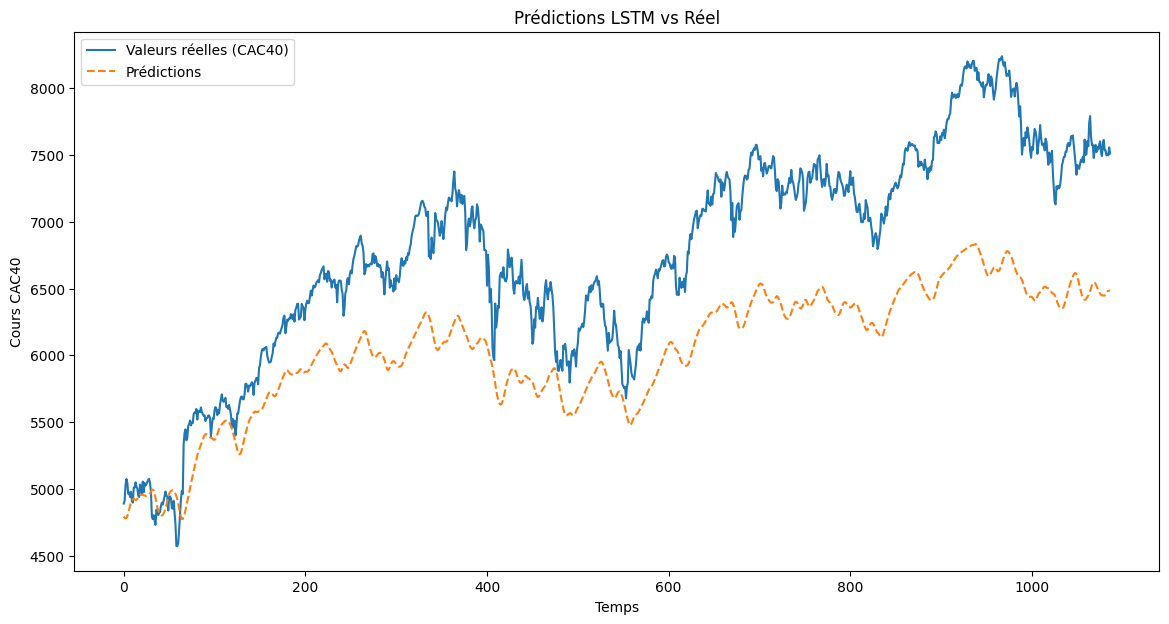

Erreur quadratique moyenne (MSE) : 637411.4739879133
Erreur absolue moyenne (MAE) : 720.878552804782
Coefficient de détermination (R²) : 0.022781800033318644


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


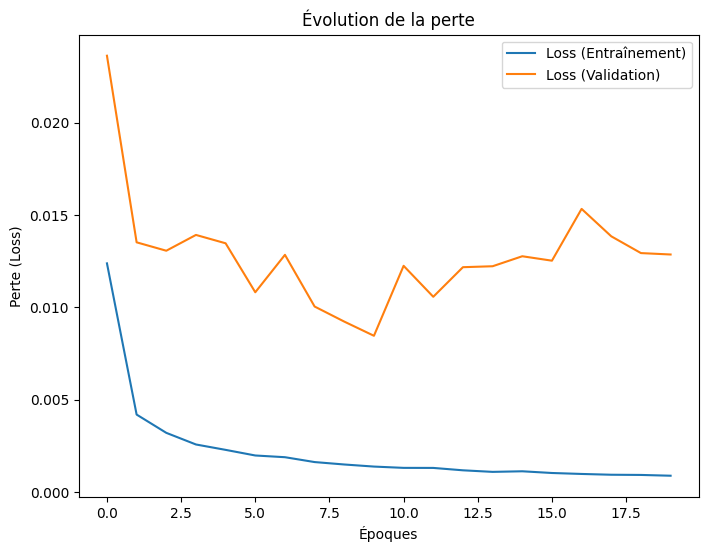

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


Le MAE est très élevé, le RMSE aussi (sqrt(MSE)), en tout cas beaucoup plus élevés que ceux observés pour les modèles similaires précédents mais avec seulement 2 couches LSTM. Nous allons donc rester sur notre architecture initiale.

## GRU: étude avec données complémentaires

A présent, nous voulons tester un modèle GRU, et comparer les performances comme on a fait avec LSTM. Nous allons utiliser là encore plusieurs tailles de sortie de couche et faire varier les hyperparamètres.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Construction du modèle GRU
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 50)              │          11,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,451 (111.14 KB)

 Trainable params: 28,451 (111.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 0.1525 - val_loss: 0.0377
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0169 - val_loss: 0.0075
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0116 - val_loss: 0.0047
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0083 - val_loss: 0.0042
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0066 - val_loss: 0.0036
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0055 - val_loss: 0.0033
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 9/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 10/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0035 - val_loss: 0.0028


In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


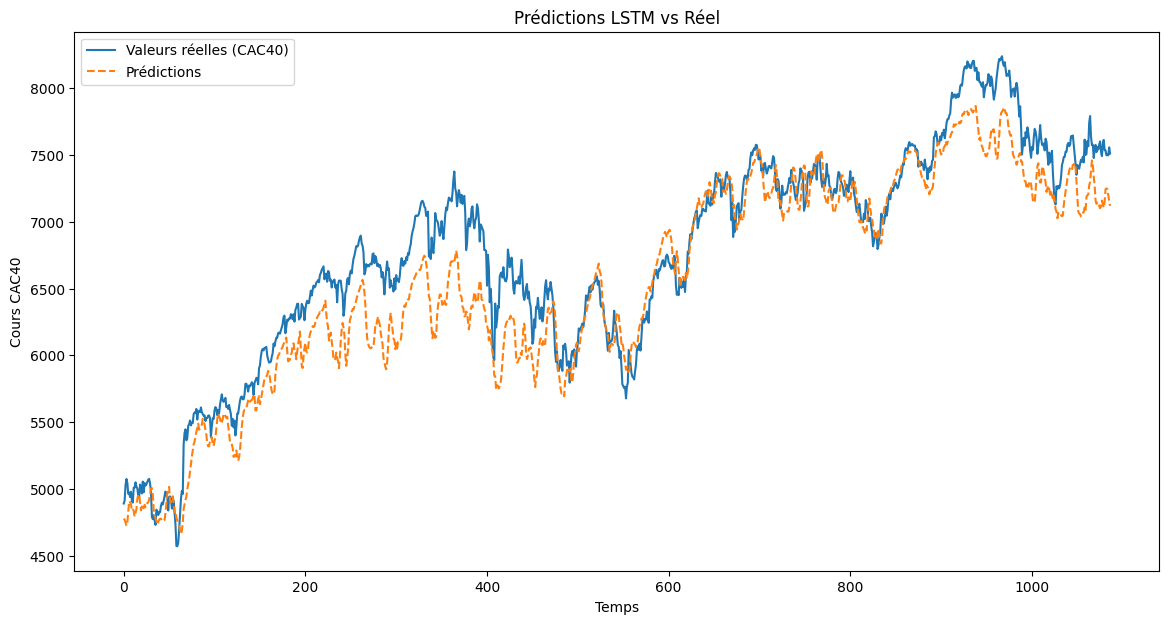

Erreur quadratique moyenne (MSE) : 93159.05710417562
Erreur absolue moyenne (MAE) : 241.99351311383936
Coefficient de détermination (R²) : 0.8571774594448829


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


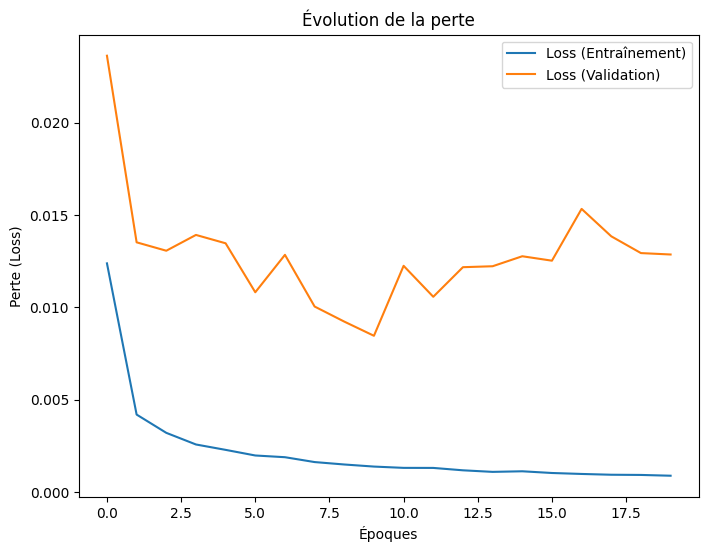

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Construction du modèle GRU
model = Sequential([
    GRU(100, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    GRU(90, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                         │ (None, 30, 100)             │          38,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 90)                  │          51,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 90)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 25)                  │           2,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,841 (362.66 KB)

 Trainable params: 92,841 (362.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)


Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.0158 - val_loss: 0.0079
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 9/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 11/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 12/15
136/136 ━━━━━━━━━━━━━━━━

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


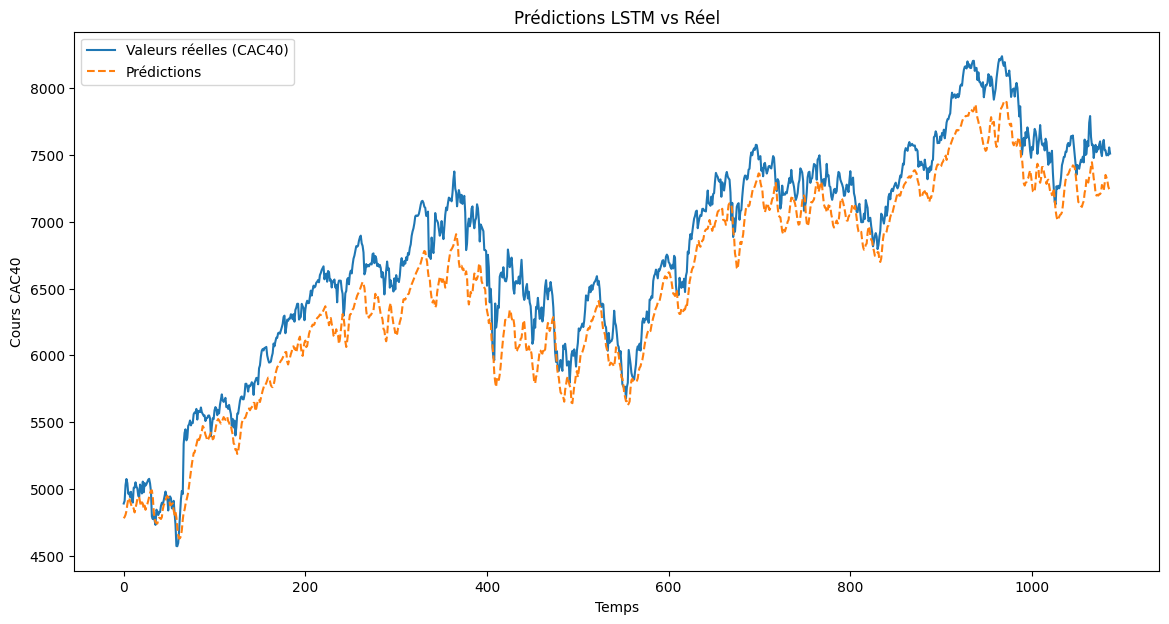

Erreur quadratique moyenne (MSE) : 79441.32233145107
Erreur absolue moyenne (MAE) : 250.86193035747544
Coefficient de détermination (R²) : 0.8782081760687201


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


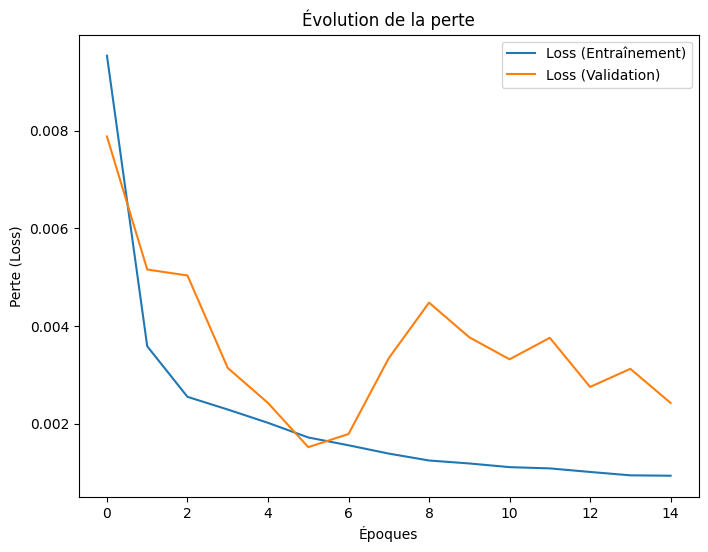

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Construction du modèle GRU
model = Sequential([
    GRU(300, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.3),
    GRU(150, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                         │ (None, 30, 300)             │         296,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 30, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ (None, 150)                 │         203,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 25)                  │           3,775 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 503,301 (1.92 MB)

 Trainable params: 503,301 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)


Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - loss: 0.0118 - val_loss: 0.0025
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 177ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 8/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 9/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 193ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 10/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 11/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 12/15
136/136

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


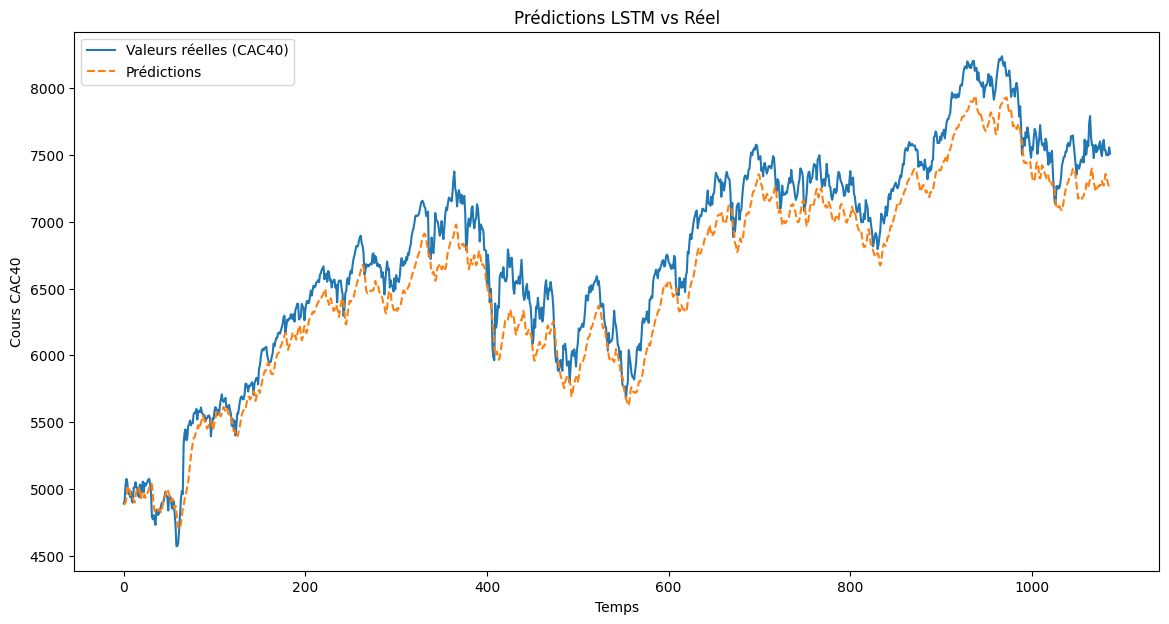

Erreur quadratique moyenne (MSE) : 54948.67371025996
Erreur absolue moyenne (MAE) : 208.72170569100712
Coefficient de détermination (R²) : 0.9157579582341893


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Valeurs réelles (CAC40)')
plt.plot(predictions_actual, label='Prédictions', linestyle='dashed')
plt.title("Prédictions LSTM vs Réel")
plt.xlabel("Temps")
plt.ylabel("Cours CAC40")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


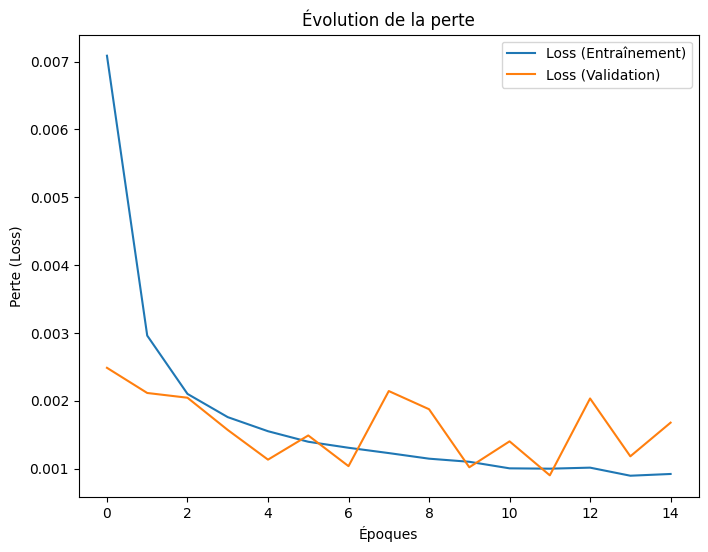

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Construction du modèle GRU
model = Sequential([
    GRU(400, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.3),
    GRU(200, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                         │ (None, 30, 400)             │         514,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 30, 400)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 200)                 │         361,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 25)                  │           5,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 881,051 (3.36 MB)

 Trainable params: 881,051 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)


Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 259ms/step - loss: 0.0209 - val_loss: 0.0035
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - loss: 0.0020 - val_loss: 9.5604e-04
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 234ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 237ms/step - loss: 0.0012 - val_loss: 7.7675e-04
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 233ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 33s 246ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 10/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - loss: 9.4000e-04 - val_loss: 8.2767e-04
Epoch 11/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - loss: 9.1115e-04 - val_loss: 0.0012

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


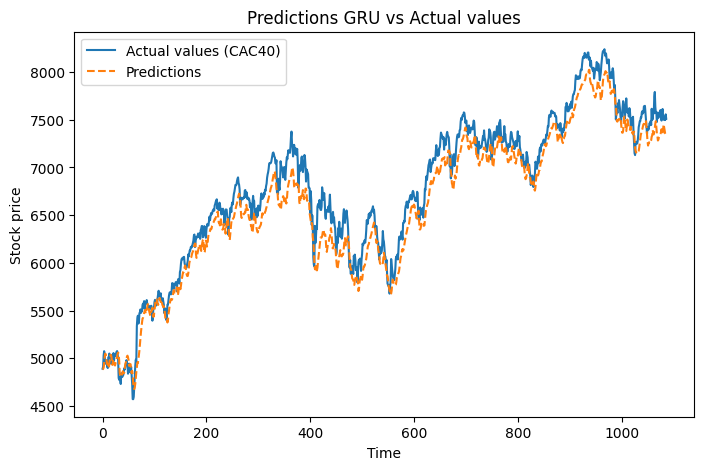

Erreur quadratique moyenne (MSE) : 40051.53874370397
Erreur absolue moyenne (MAE) : 171.27710594857882
Coefficient de détermination (R²) : 0.9385968182339931


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(8, 5))
plt.plot(y_test_actual, label='Actual values (CAC40)')
plt.plot(predictions_actual, label='Predictions', linestyle='dashed')
plt.title("Predictions GRU vs Actual values")
plt.xlabel("Time")
plt.ylabel("Stock price")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


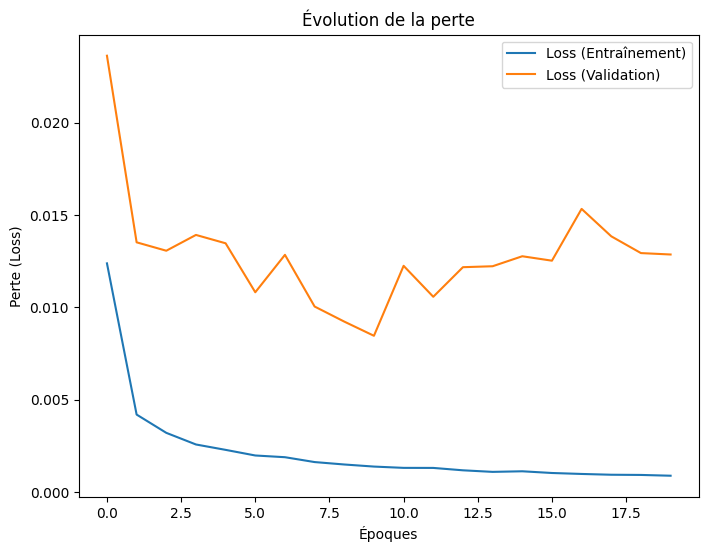

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


Les performances délivrées par GRU sont meilleures que celles obtenues avec LSTM. Toutes les métriques d'évaluation des prédictions s'améliorent. En effet, les modèles GRU sont légèrement moins complexes que LSTM en terme d'architecture, ce qui peut-être permet une meilleure généralisation lors de prédictions sur des données test.

## Meilleurs modèles

Ici, nous allons afficher les bouts de code qui permettent de générer les meilleurs modèles obtenues après notre optimisation des hyperparamètres. Une présentation plus détaillée de l'appri=oche de modélisation ainsi qu'une discussion des limites de nos résultats est présente dans le rapport.

### Etude purement temporelle avec LSTM

In [ ]:
import yfinance as yf

# données du CAC40 (^FCHI)
data = yf.download("^FCHI", start="1990-01-01", end="2023-12-31", interval="1d")

# aperçu
print(data.head())

# on extrait les prix de clôture
close_prices = data["Close"]


[*********************100%***********************]  1 of 1 completed

Price        Close    High     Low    Open Volume
Ticker       ^FCHI   ^FCHI   ^FCHI   ^FCHI  ^FCHI
Date                                             
1990-03-01  1832.0  1838.0  1827.0  1836.0      0
1990-03-02  1860.0  1860.0  1831.0  1831.0      0
1990-03-05  1874.0  1874.0  1862.0  1866.0      0
1990-03-06  1872.0  1875.0  1866.0  1869.0      0
1990-03-07  1880.0  1881.0  1874.0  1874.0      0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(close_prices.values.reshape(-1, 1))


L'apprentissage avec LSTM fonctionne avec des séquences temporelles.  Il s'agit de séries d'observations sur un temps déterminé qui sont utilisées pour faire des prédictions.

In [ ]:
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

SEQ_LENGTH = 60  # Par exemple, utiliser 60 jours pour prédire le jour suivant
x, y = create_sequences(scaled_prices, SEQ_LENGTH)


In [ ]:
# séparation en échantillons d'apprentissage et test

split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Vérification des dimensions
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")


x_train shape: (6824, 60, 1), x_test shape: (1706, 60, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Une seule sortie pour prédire la prochaine valeur
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 0.0160 - val_loss: 4.5287e-04
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0013 - val_loss: 5.9428e-04
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - loss: 9.5708e-04 - val_loss: 5.4202e-04
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - loss: 8.2180e-04 - val_loss: 4.1825e-04
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 6.7347e-04 - val_loss: 3.8435e-04
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 6.3762e-04 - val_loss: 3.0331e-04
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 5.9338e-04 - val_loss: 3.0730e-04
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 5.3210e-04 - val_loss: 2.8841e-04
Epoch 9/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - loss: 5.3819e-04 - val_loss: 2.9695e-04
Epoch 10/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 5.4904e-04 - val_loss: 3.7744e-04
Epoch 11/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 65

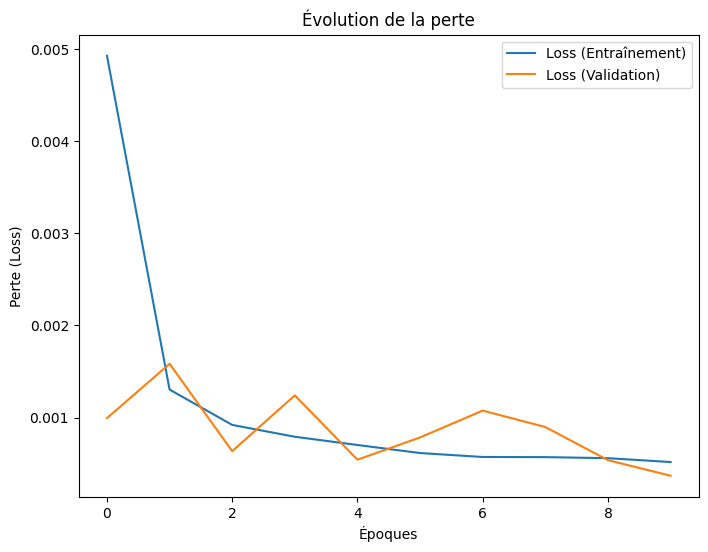

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # remettre à l'échelle d'origine pour pouvoir comparer après


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


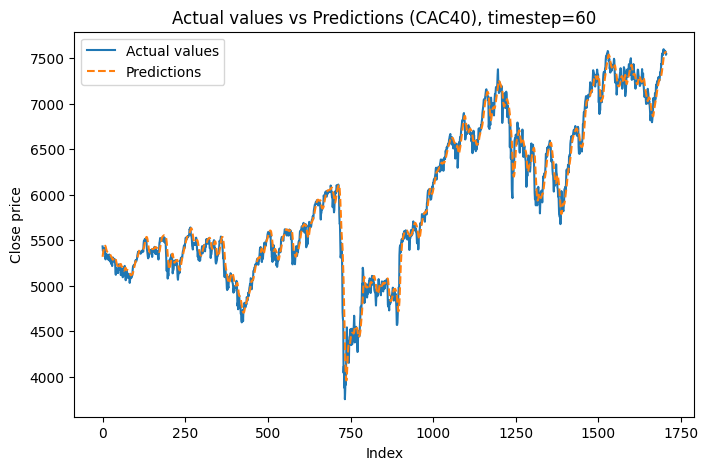

In [ ]:
true_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisation des vraies valeurs vs prédictions
plt.figure(figsize=(8, 5))
plt.plot(true_values, label="Actual values")
plt.plot(predictions, label="Predictions", linestyle="--")
plt.title("Actual values vs Predictions (CAC40), timestep=60")
plt.xlabel("Index")
plt.ylabel("Close price")
plt.legend()
plt.show()


Affichage des métriques d'erreur

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [ ]:
# Calcul des métriques
r2 = r2_score(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, predictions)

# Afficher les résultats
print(f"R2 score : {r2}")
print(f"Mean Squared Error (MSE) : {mse}")
print(f"Root Mean Squared Error (RMSE) : {rmse}")
print(f"Mean Absolute Error (MAE) : {mae}")


R2 score : 0.9799845914609255
Mean Squared Error (MSE) : 13977.740226493808
Root Mean Squared Error (RMSE) : 118.22749353045512
Mean Absolute Error (MAE) : 79.97318646161527


### Etude avec des données macro-économiques et autres indicateurs

#### LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Importation des données

data = pd.read_csv("../data/output/final_database.csv")

# Vérifier les données
print(data.head())
print(data.info())



         Date          GDPV       IRL       IRS           GDP  CPIH_YTYPCT  \
0  2000-01-03  1.922807e+12  5.578081  3.558156  1.447856e+12     1.567372   
1  2000-01-04  1.923032e+12  5.576022  3.566075  1.448057e+12     1.566982   
2  2000-01-05  1.923257e+12  5.573963  3.573995  1.448258e+12     1.566592   
3  2000-01-06  1.923482e+12  5.571903  3.581915  1.448459e+12     1.566202   
4  2000-01-07  1.923707e+12  5.569844  3.589835  1.448660e+12     1.565812   

       IRCB       UNR           YPH    UNR_us  ...        WMA_5       WMA_10  \
0  2.516484  9.098174  4.838564e+11  4.047578  ...  5876.351986  5799.456934   
1  2.524725  9.093994  4.839066e+11  4.046468  ...  5894.800684  5835.060405   
2  2.532967  9.089814  4.839568e+11  4.045357  ...  5827.141341  5818.509854   
3  2.541209  9.085634  4.840070e+11  4.044247  ...  5706.205404  5764.248242   
4  2.549451  9.081453  4.840572e+11  4.043137  ...  5598.564681  5705.507298   

        WMA_20    Momentum        RSI  Williams_R 

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [ ]:
print(data.isnull().sum())

GDPV                  0
IRL                   0
IRS                   0
GDP                   0
CPIH_YTYPCT           0
IRCB                  0
UNR                   0
YPH                   0
UNR_us                0
IRCB_us             886
CPI_us                0
Close                 0
Return                0
High_minus_Low        0
Close_minus_Open      0
SMA_5                 0
SMA_10                0
SMA_20                0
WMA_5                 0
WMA_10                0
WMA_20                0
Momentum              0
RSI                   0
Williams_R            0
Stochastic_K          0
Stochastic_D          0
CCI                   0
MACD                  0
dtype: int64


In [ ]:
print(data.shape)

(6347, 28)


Nous avons toujours les données manquantes pour IRCB_us.

Finalement, nous allons supprimer les lignes qui contiennent les valeurs manquantes pour IRCB_us, elles sont toutes en début de table: il ne s'agit propablement pas de "missing at random values". En imputant des valeurs, quelle que soit la méthode, on risque d'introduire du biais.

In [ ]:
# Supprimer les lignes contenant des valeurs manquantes uniquement pour la colonne 'IRCB_us'
data_cleaned = data.dropna(subset=['IRCB_us'])

# Vérifier les dimensions du DataFrame après la suppression
print(f"Taille des données avant suppression : {data.shape}")
print(f"Taille des données après suppression : {data_cleaned.shape}")

# Vérifier qu'il n'y a plus de valeurs manquantes dans 'IRCB_us'
print(data_cleaned['IRCB_us'].isnull().sum())


Taille des données avant suppression : (6347, 28)
Taille des données après suppression : (5461, 28)
0


In [ ]:
data = data_cleaned

In [ ]:
# on va déplacer la colonne cible en dernière position du dataframe pour réutiliser notre fonction de création de séquences

column_to_move = "Close"
cols = [col for col in data.columns if col != column_to_move]
data = data[cols + [column_to_move]]

# Vérifier que la colonne "Close" est bien en dernière position
print(data.columns)


Index(['GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR', 'YPH',
       'UNR_us', 'IRCB_us', 'CPI_us', 'Return', 'High_minus_Low',
       'Close_minus_Open', 'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10',
       'WMA_20', 'Momentum', 'RSI', 'Williams_R', 'Stochastic_K',
       'Stochastic_D', 'CCI', 'MACD', 'Close'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd

# Paramètres
lookback = 30  # Nombre de jours dans chaque séquence

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaled_data = scaler.fit_transform(data)

In [ ]:


def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :-1])  # Toutes les colonnes sauf la cible (Close)
        y.append(data[i+lookback, -1])    # La cible est Close
        print()
    return np.array(X), np.array(y)

# Charger les données nettoyées
data_narray = data.values  # Convertir le DataFrame en numpy array
X, y = create_sequences(data_narray, lookback)

# Diviser en ensembles d'entraînement et de test
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Forme des données d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Forme des données de test : {X_test.shape}, {y_test.shape}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normaliser toutes les colonnes
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Recréer les séquences avec les données normalisées
X, y = create_sequences(data_scaled, lookback)

# Diviser à nouveau en ensemble d'entraînement et de test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Vérifier les formes
print(f"Données normalisées - X_train : {X_train.shape}, y_train : {y_train.shape}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    # on précise ici qu'il y a des séquences de données antérieures à prendre en compte (lookback)
    LSTM(400, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.3),
    LSTM(200, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 30, 400)             │         684,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 30, 400)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 200)                 │         480,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 25)                  │           5,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,170,651 (4.47 MB)

 Trainable params: 1,170,651 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - loss: 0.0500 - val_loss: 0.0112
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 44s 304ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 80s 292ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - loss: 0.0027 - val_loss: 9.6813e-04
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 42s 299ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 291ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 294ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 10/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 287ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 11/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 12/20
136

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step


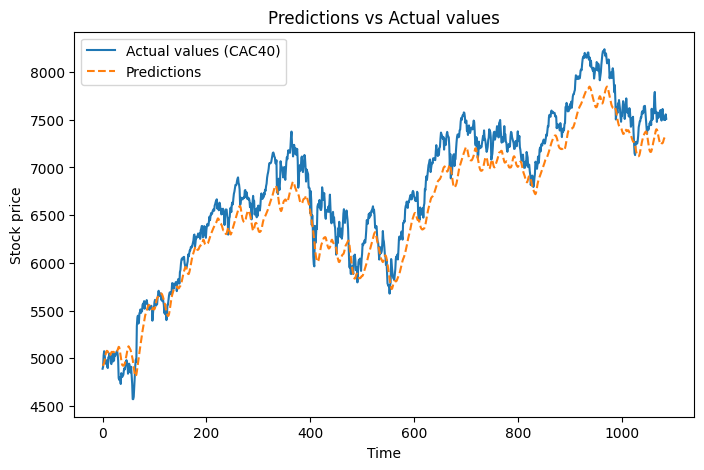

Erreur quadratique moyenne (MSE) : 70931.91136952072
Erreur absolue moyenne (MAE) : 233.14649087675502
Coefficient de détermination (R²) : 0.8912539896480847


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(8, 5))
plt.plot(y_test_actual, label='Actual values (CAC40)')
plt.plot(predictions_actual, label='Predictions', linestyle='dashed')
plt.title("Predictions vs Actual values")
plt.xlabel("Time")
plt.ylabel("Stock price")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


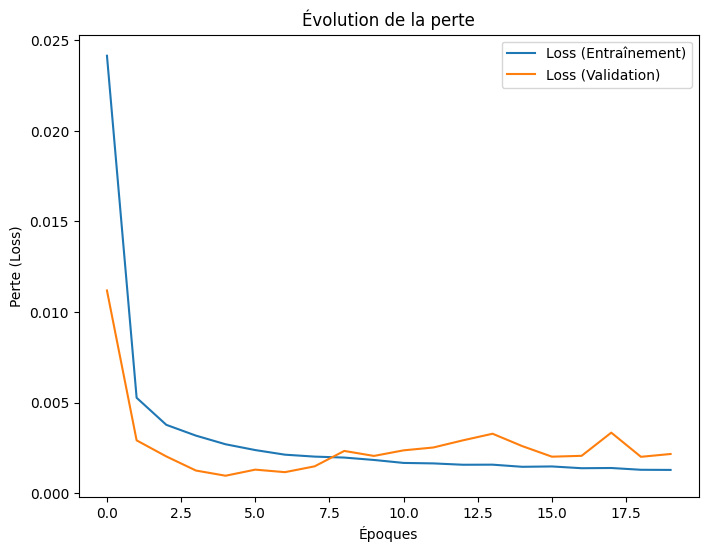

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()


#### GRU

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Importation des données

data = pd.read_csv("../data/output/final_database.csv")

# Vérifier les données
print(data.head())
print(data.info())



         Date          GDPV       IRL       IRS           GDP  CPIH_YTYPCT  \
0  2000-01-03  1.922807e+12  5.578081  3.558156  1.447856e+12     1.567372   
1  2000-01-04  1.923032e+12  5.576022  3.566075  1.448057e+12     1.566982   
2  2000-01-05  1.923257e+12  5.573963  3.573995  1.448258e+12     1.566592   
3  2000-01-06  1.923482e+12  5.571903  3.581915  1.448459e+12     1.566202   
4  2000-01-07  1.923707e+12  5.569844  3.589835  1.448660e+12     1.565812   

       IRCB       UNR           YPH    UNR_us  ...        WMA_5       WMA_10  \
0  2.516484  9.098174  4.838564e+11  4.047578  ...  5876.351986  5799.456934   
1  2.524725  9.093994  4.839066e+11  4.046468  ...  5894.800684  5835.060405   
2  2.532967  9.089814  4.839568e+11  4.045357  ...  5827.141341  5818.509854   
3  2.541209  9.085634  4.840070e+11  4.044247  ...  5706.205404  5764.248242   
4  2.549451  9.081453  4.840572e+11  4.043137  ...  5598.564681  5705.507298   

        WMA_20    Momentum        RSI  Williams_R 

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [ ]:
print(data.isnull().sum())

GDPV                  0
IRL                   0
IRS                   0
GDP                   0
CPIH_YTYPCT           0
IRCB                  0
UNR                   0
YPH                   0
UNR_us                0
IRCB_us             886
CPI_us                0
Close                 0
Return                0
High_minus_Low        0
Close_minus_Open      0
SMA_5                 0
SMA_10                0
SMA_20                0
WMA_5                 0
WMA_10                0
WMA_20                0
Momentum              0
RSI                   0
Williams_R            0
Stochastic_K          0
Stochastic_D          0
CCI                   0
MACD                  0
dtype: int64


In [ ]:
print(data.shape)

(6347, 28)


Nous avons toujours les données manquantes pour IRCB_us.

Finalement, nous allons supprimer les lignes qui contiennent les valeurs manquantes pour IRCB_us, elles sont toutes en début de table: il ne s'agit propablement pas de "missing at random values". En imputant des valeurs, quelle que soit la méthode, on risque d'introduire du biais.

In [ ]:
# Supprimer les lignes contenant des valeurs manquantes uniquement pour la colonne 'IRCB_us'
data_cleaned = data.dropna(subset=['IRCB_us'])

# Vérifier les dimensions du DataFrame après la suppression
print(f"Taille des données avant suppression : {data.shape}")
print(f"Taille des données après suppression : {data_cleaned.shape}")

# Vérifier qu'il n'y a plus de valeurs manquantes dans 'IRCB_us'
print(data_cleaned['IRCB_us'].isnull().sum())


Taille des données avant suppression : (6347, 28)
Taille des données après suppression : (5461, 28)
0


In [ ]:
data = data_cleaned

In [ ]:
# on va déplacer la colonne cible en dernière position du dataframe pour réutiliser notre fonction de création de séquences

column_to_move = "Close"
cols = [col for col in data.columns if col != column_to_move]
data = data[cols + [column_to_move]]

# Vérifier que la colonne "Close" est bien en dernière position
print(data.columns)


Index(['GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR', 'YPH',
       'UNR_us', 'IRCB_us', 'CPI_us', 'Return', 'High_minus_Low',
       'Close_minus_Open', 'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10',
       'WMA_20', 'Momentum', 'RSI', 'Williams_R', 'Stochastic_K',
       'Stochastic_D', 'CCI', 'MACD', 'Close'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd

# Paramètres
lookback = 30  # Nombre de jours dans chaque séquence

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaled_data = scaler.fit_transform(data)

In [ ]:


def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :-1])  # Toutes les colonnes sauf la cible (Close)
        y.append(data[i+lookback, -1])    # La cible est Close
        print()
    return np.array(X), np.array(y)

# Charger les données nettoyées
data_narray = data.values  # Convertir le DataFrame en numpy array
X, y = create_sequences(data_narray, lookback)

# Diviser en ensembles d'entraînement et de test
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Forme des données d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Forme des données de test : {X_test.shape}, {y_test.shape}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normaliser toutes les colonnes
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Recréer les séquences avec les données normalisées
X, y = create_sequences(data_scaled, lookback)

# Diviser à nouveau en ensemble d'entraînement et de test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Vérifier les formes
print(f"Données normalisées - X_train : {X_train.shape}, y_train : {y_train.shape}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Construction du modèle GRU
model = Sequential([
    GRU(400, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.3),
    GRU(200, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour prédire CAC40 (colonne "Close")
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                         │ (None, 30, 400)             │         514,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 30, 400)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 200)                 │         361,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 25)                  │           5,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 881,051 (3.36 MB)

 Trainable params: 881,051 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiler le modèle
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)


Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 259ms/step - loss: 0.0209 - val_loss: 0.0035
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - loss: 0.0020 - val_loss: 9.5604e-04
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 234ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 237ms/step - loss: 0.0012 - val_loss: 7.7675e-04
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 233ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 33s 246ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 10/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - loss: 9.4000e-04 - val_loss: 8.2767e-04
Epoch 11/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - loss: 9.1115e-04 - val_loss: 0.0012

In [ ]:
# Faire des prédictions
predictions = model.predict(X_test)

# Reconvertir les prédictions et les vraies valeurs à leur échelle originale
y_test_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
predictions_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), data.shape[1]-1)), predictions], axis=1))[:, -1]


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


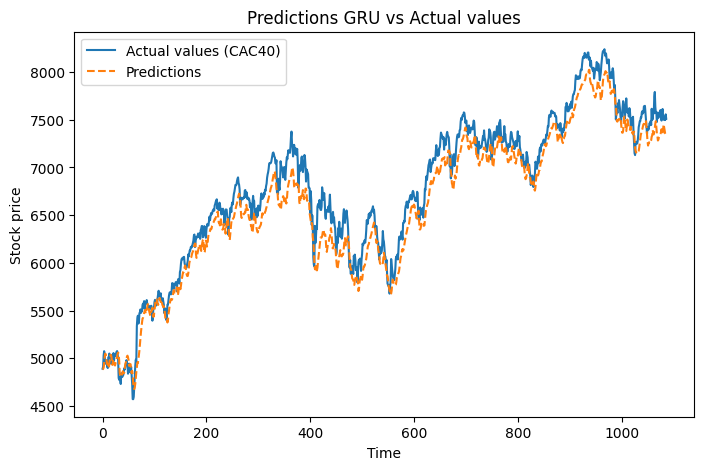

Erreur quadratique moyenne (MSE) : 40051.53874370397
Erreur absolue moyenne (MAE) : 171.27710594857882
Coefficient de détermination (R²) : 0.9385968182339931


In [ ]:
import matplotlib.pyplot as plt

# Visualiser les vraies valeurs et les prédictions
plt.figure(figsize=(8, 5))
plt.plot(y_test_actual, label='Actual values (CAC40)')
plt.plot(predictions_actual, label='Predictions', linestyle='dashed')
plt.title("Predictions GRU vs Actual values")
plt.xlabel("Time")
plt.ylabel("Stock price")
plt.legend()
plt.show()

# Calcul des métriques de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Coefficient de détermination (R²) : {r2}")


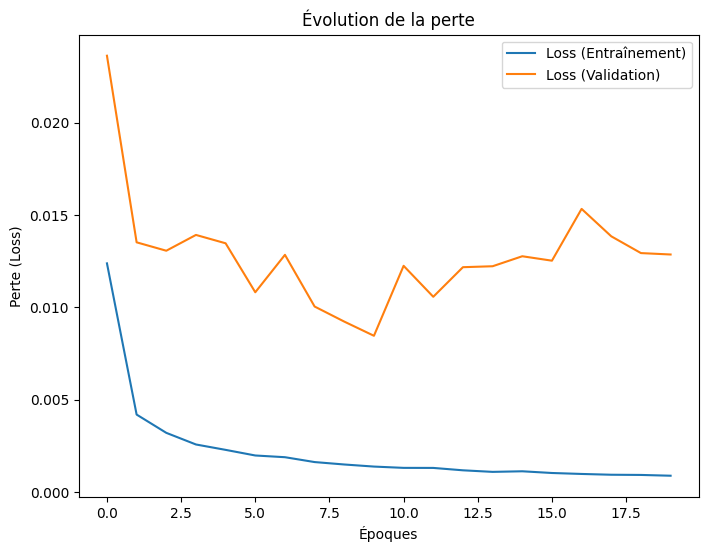

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()
